In [1]:
import numpy as np
import sipm.sipm as sipm
import sipm.dataset as ds
import sipm.beta as beta
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sipm.constants as const
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Read SiPM pulse shape from csv

In [ ]:
import csv
pulse_pars_top = []
pulse_pars_bot = []
with open('pulse_parameters_65V.csv') as f:
    r = csv.reader(f)
    line_count = 0
    for row in r:
        if line_count>0:
            if line_count<=4:
                pulse_pars_top.append([float(par) for par in row[1:]])
                print(pulse_pars_top[-1])
            else:
                pulse_pars_bot.append([float(par) for par in row[1:]])
                print(pulse_pars_bot[-1])
        line_count += 1


[4.785269765091801, 0.24465717230046793, 4.073501733077282, 0.019567625094531624]
[1.6673254424459918, 0.47719420237660765, 4.903429623168718, 0.08571027976327786]
[1.7772347297673032, 0.420307822140636, 5.259472382086961, 0.06012379531673089]
[5.46460121203827, 0.27214909992926917, 4.358305910658269, 0.011102848302532735]
[3.159016495606167, 0.3970144047422518, 4.072443314855156, 0.04496687268229123]
[0.9718248355955384, 0.8285785218030871, 5.524493722728364, 0.1028647225158728]
[1.382881398253107, 0.7346785481410949, 5.30060245748518, 0.07496312866265117]
[0.7145097171380426, 0.8118939509327021, 5.570884898422146, 0.0740521372552768]


# List of Datasets
- Bottom:
    * 11/07: 1-6, overnight
    * 11/09: high stat
    * 11/10: high stat, overnight
- Top:
    * 11/08: 0, overnight
    * 11/09: high stat
    * 11/10: high stat

# Bottom 11/07 11/09 11/10 Day

In [2]:
# subdir: 0-9
dir1107bot = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_purification_1/'
#subdir: 0-19
dir1109bot = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_high_stat/'
#subdir: 0-19
dir1110bot = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_bottom_light_scintillation_coinc_111_cond_gamma_high_stat/'

In [3]:
ds_bot = []
nsubdir = [10,20,20]
# gain = [[T0,T1,T2,T3],[B0,B1,B2,B3]]
gain = [[526.15408, 519.05546, 507.44070, 521.98428], [518.84503, 510.84132, 504.40531, 457.59589]]
for i,dir in enumerate([dir1107bot, dir1109bot, dir1110bot]):
    for j in range(nsubdir[i]):
        subdir = '{}{}/'.format(dir, j)
        print(subdir)
        data = ds.Dataset(subdir, pol=-1, channels=range(4), spe=gain[1])
        for ch in range(4):
            data.ch[ch].path = subdir
            data.ch[ch].read_data()
            data.ch[ch].baseline_subtraction()
            data.ch[ch].get_integral(prompt=0.5, long=5)
            data.ch[ch].get_avgwf(integral_range=[5*data.gain[ch], 100*data.gain[ch]])
            data.ch[ch].clear()
    data.get_summed_integral_pe()
    data.get_fprompt()
    ds_bot.append(data)

/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_purification_1/0/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_purification_1/1/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_purification_1/2/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_purification_1/3/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_purification_1/4/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_purification_1/5/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/20

## Deconvolution channel by channel

ch0 A_S=1.80+/-0.02  TAU_S=0.0289+/-0.0005us  A_T=0.19+/-0.00  TAU_T=0.637+/-0.014us sigma=0.0084+/-0.0002us t0=6.258+/-0.000us
ch1 A_S=2.88+/-0.05  TAU_S=0.0211+/-0.0005us  A_T=0.25+/-0.00  TAU_T=0.614+/-0.012us sigma=0.0095+/-0.0002us t0=6.258+/-0.000us
ch2 A_S=2.62+/-0.03  TAU_S=0.0215+/-0.0003us  A_T=0.25+/-0.00  TAU_T=0.618+/-0.008us sigma=0.0089+/-0.0001us t0=6.257+/-0.000us
ch3 A_S=1.97+/-0.03  TAU_S=0.0246+/-0.0005us  A_T=0.19+/-0.00  TAU_T=0.795+/-0.016us sigma=0.0083+/-0.0002us t0=6.258+/-0.000us
ch0 A_S=1.66+/-0.02  TAU_S=0.0305+/-0.0005us  A_T=0.18+/-0.00  TAU_T=1.159+/-0.018us sigma=0.0083+/-0.0002us t0=6.257+/-0.000us
ch1 A_S=2.30+/-0.04  TAU_S=0.0192+/-0.0004us  A_T=0.12+/-0.00  TAU_T=1.731+/-0.034us sigma=0.0087+/-0.0002us t0=6.259+/-0.000us
ch2 A_S=2.03+/-0.02  TAU_S=0.0236+/-0.0003us  A_T=0.18+/-0.00  TAU_T=1.255+/-0.014us sigma=0.0089+/-0.0001us t0=6.255+/-0.000us
ch3 A_S=1.68+/-0.02  TAU_S=0.0342+/-0.0006us  A_T=0.24+/-0.00  TAU_T=1.296+/-0.018us sigma=0.0085+/-0.00

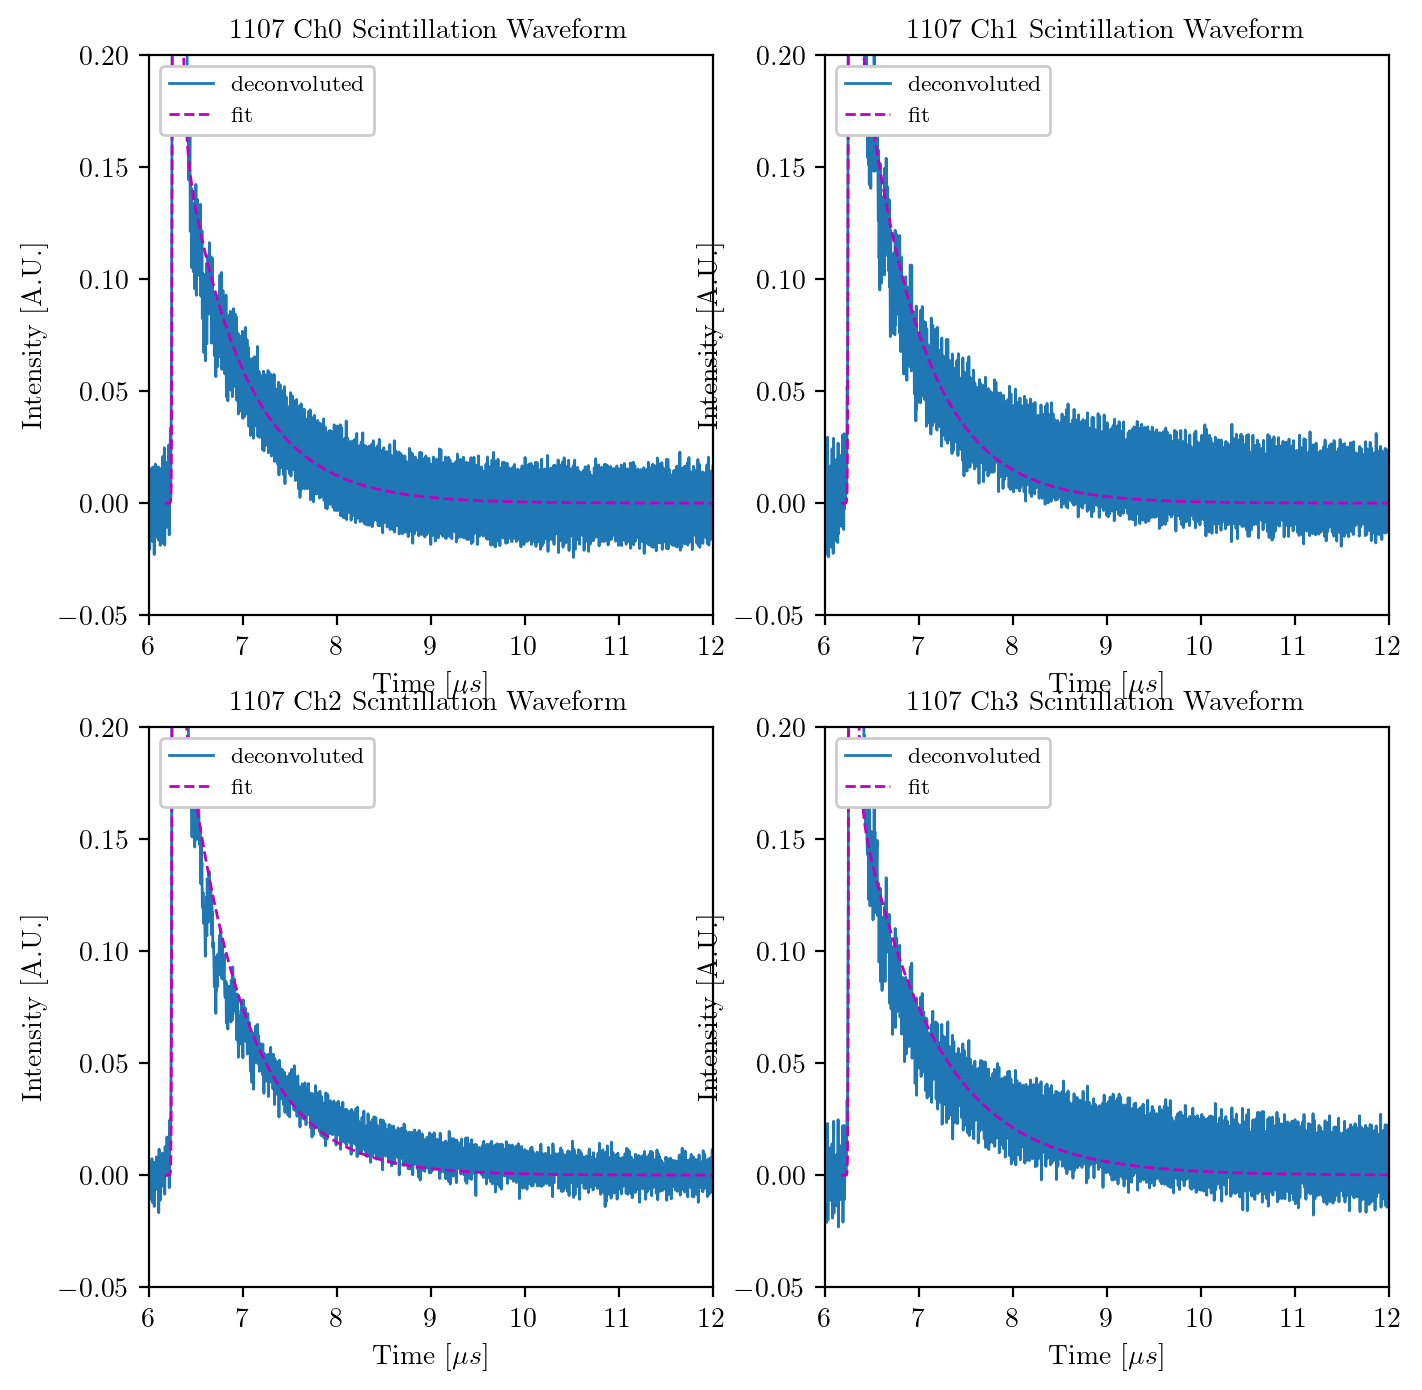

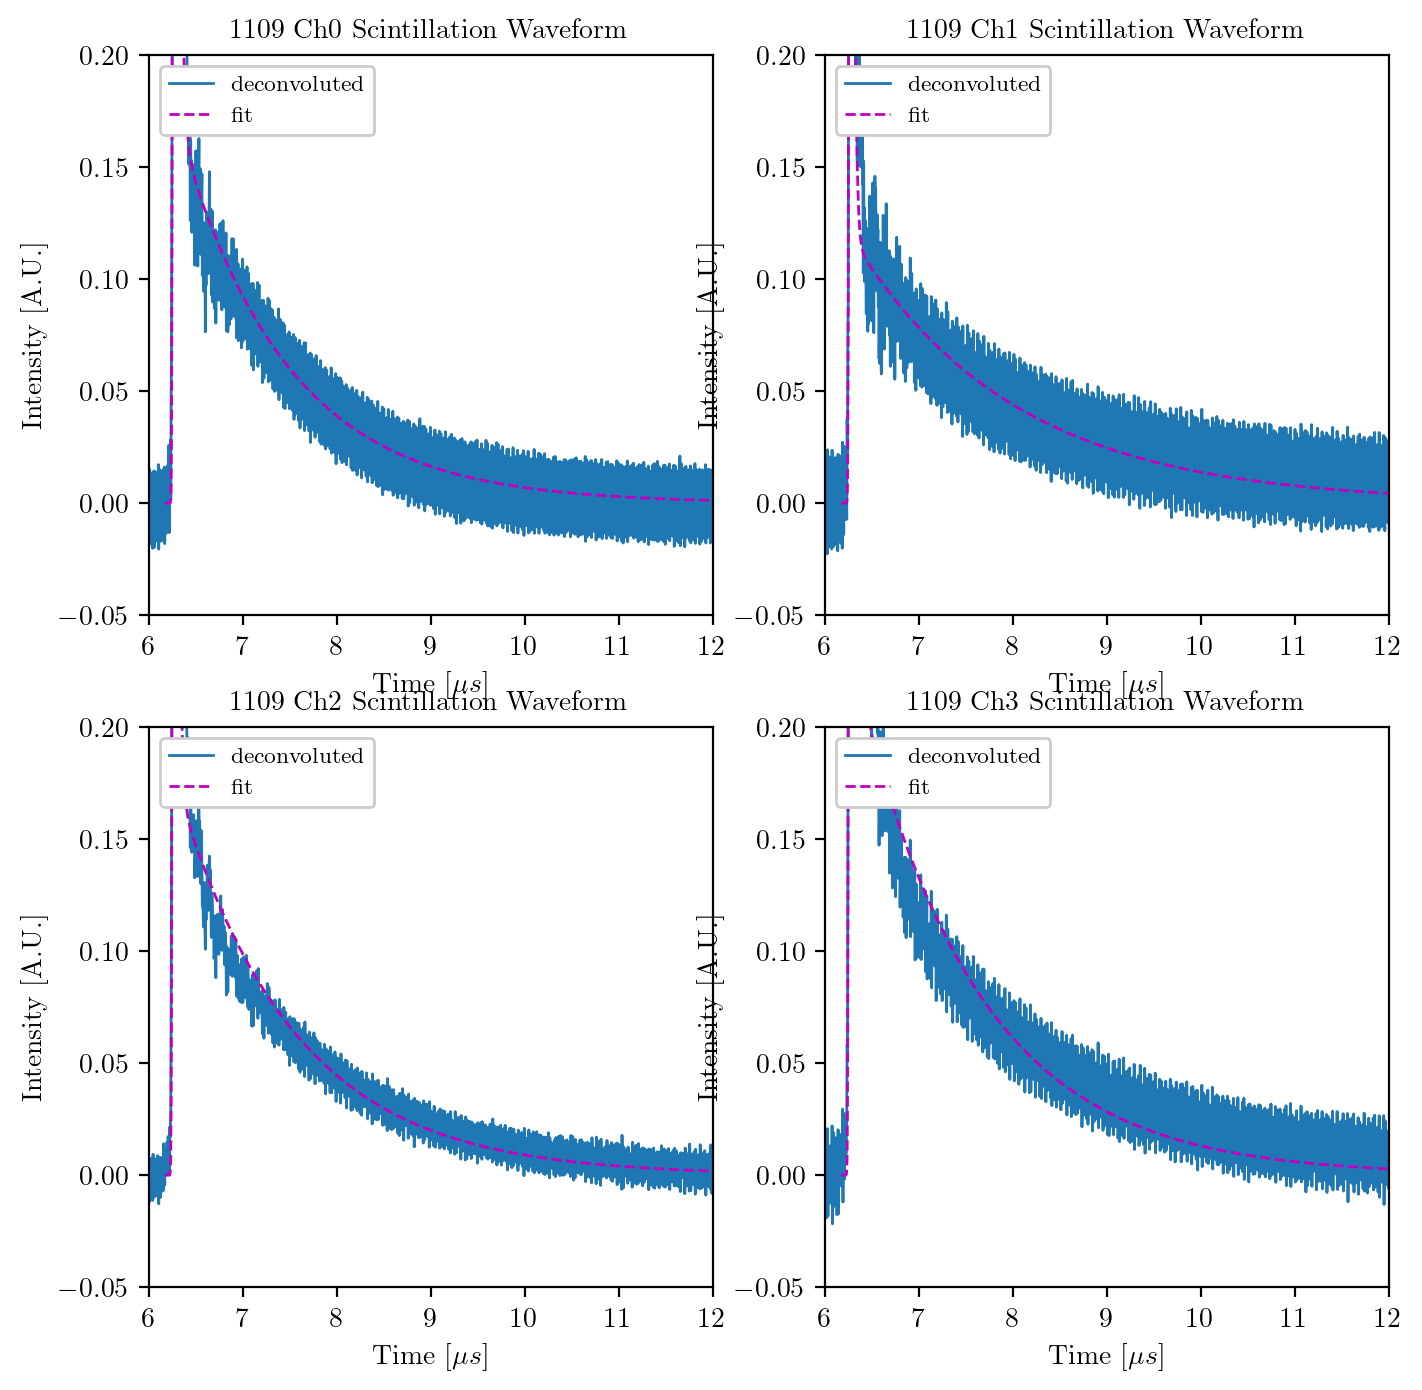

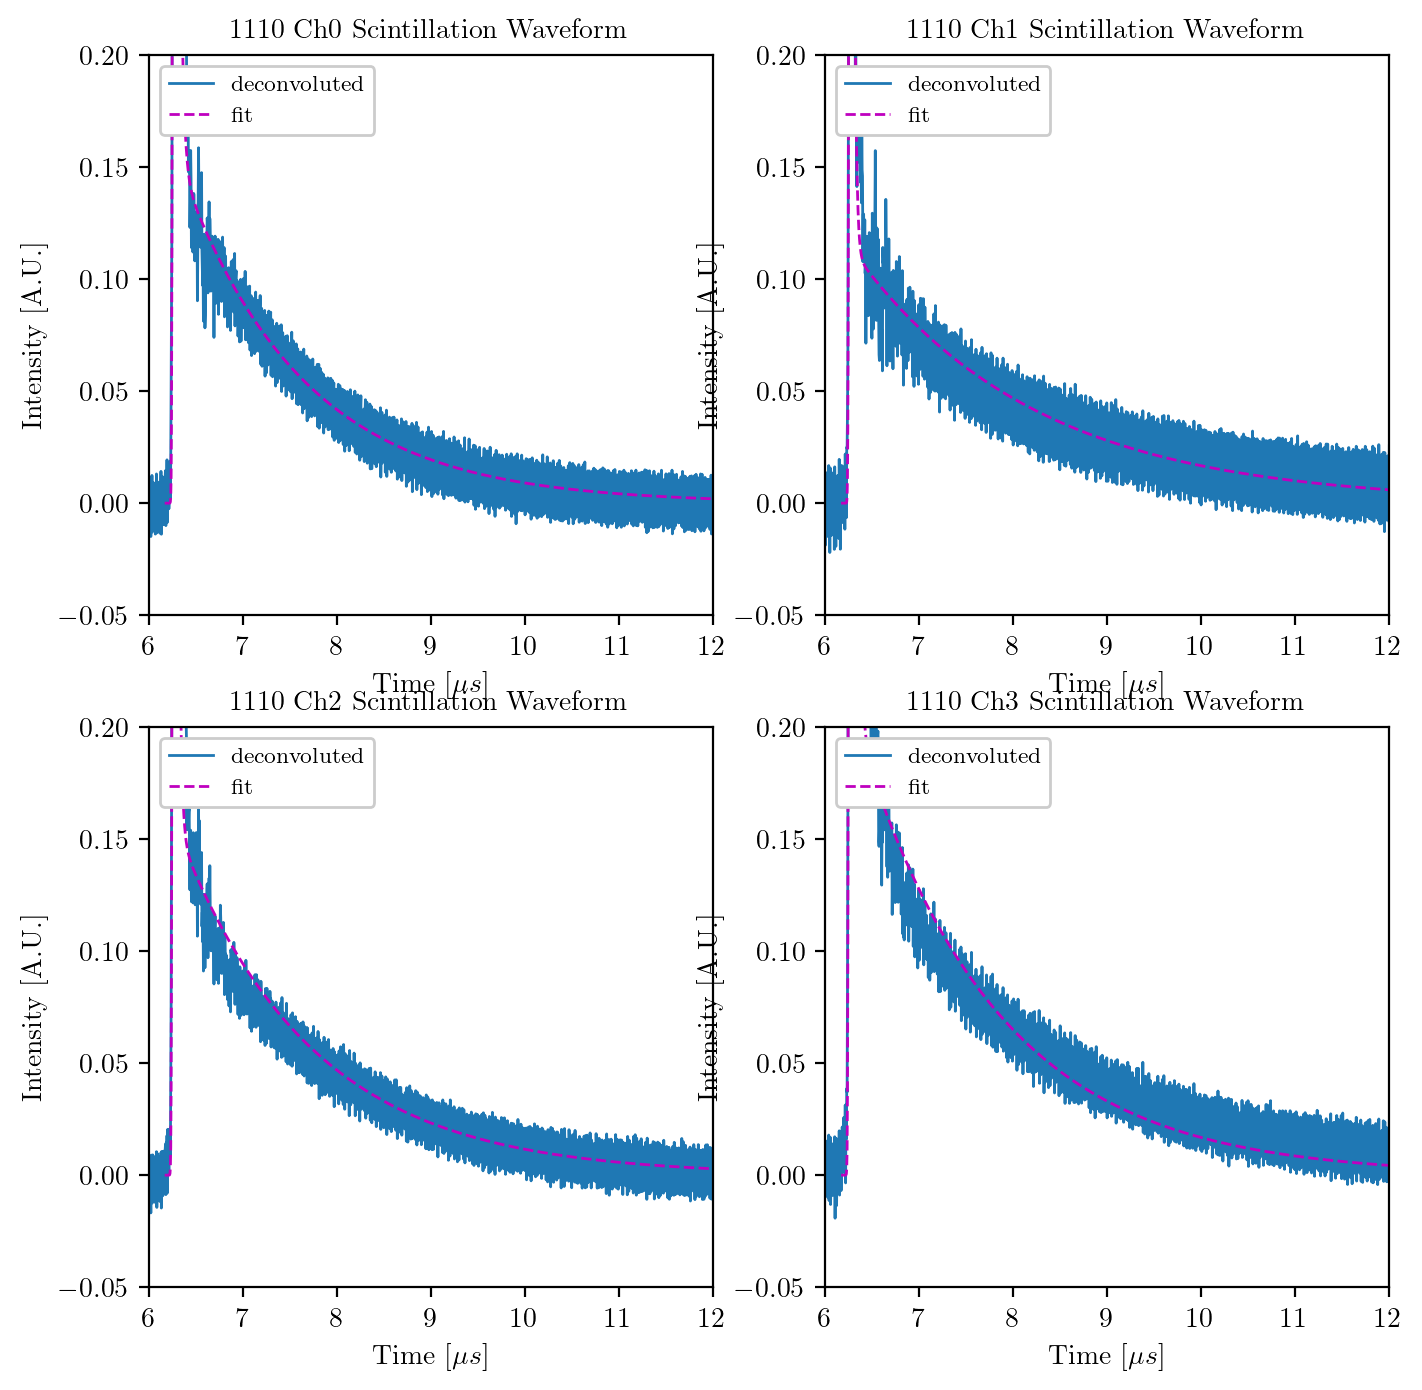

In [5]:
from scipy.fft import fft, ifft
f_deconv_sum_bot = []
date = ['1107','1109','1110']
for i,dset in enumerate(ds_bot):
    plt.figure(i,figsize=(8,8))
    f_deconv_sum_day = np.zeros(dset.ch[0].samples)
    for ch in range(4):
        dset.ch[ch].set_pulse_pars(*pulse_pars_bot[ch])
        ftilde = fft(dset.ch[ch].avgwf)
        a1,tau1,a2,tau2 = dset.ch[ch].get_pulse_pars()
        h = lambda x: a1*np.exp(-x/tau1)+a2*np.exp(-x/tau2)
        htilde = fft(h(dset.ch[ch].time))
        f_deconv = ifft(ftilde/htilde).real
        f_deconv_sum_day += f_deconv
        t0 = np.argmax(f_deconv)-int(0.1/dset.ch[ch].sample_step)
        length = int(6/dset.ch[ch].sample_step)
        err = np.std(dset.ch[ch].avgwf[:dset.ch[ch].baseline_samples])
        popt,pcov = curve_fit(dset.ch[ch].get_scintillation, dset.ch[ch].time[t0:t0+length], f_deconv[t0:t0+length], p0=[1, 0.02, 0.1, 1.2, 0.01, 6.25], sigma=[err]*length, maxfev=100000)
        print('ch{} A_S={:.2f}+/-{:.2f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.2f}+/-{:.2f}  TAU_T={:.3f}+/-{:.3f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(ch,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
        dset.ch[ch].tau_singlet = [popt[1], np.sqrt(pcov[1,1])]
        dset.ch[ch].tau_triplet = [popt[3], np.sqrt(pcov[3,3])]
        plt.subplot(2,2,ch+1)
        plt.plot(dset.ch[ch].time, f_deconv, label='deconvoluted', linewidth=1)
        plt.plot(dset.ch[ch].time[t0:t0+length], dset.ch[ch].get_scintillation(dset.ch[ch].time[t0:t0+length], *popt), "m--", label='fit', linewidth=1)
        plt.title('{} Ch{} Scintillation Waveform'.format(date[i],ch))
        plt.ylabel('Intensity [A.U.]')
        plt.xlabel(r'Time [$\mu s$]')
        plt.legend()
        # plt.yscale('log')
        # plt.ylim(1e-3, 1e1)
        plt.ylim(-0.05,0.2)
        plt.xlim(6,12)
    f_deconv_sum_bot.append(f_deconv_sum_day)

## Summed scintillation pulse

11/07 A_S=4.7726+/-1663265.5822  TAU_S=0.1056+/-0.0021us  A_T=0.5672+/-20366.6483  TAU_T=1.0613+/-0.0131us sigma=0.0285+/-6029.4956us t0=6.1462+/-38250.3330us
11/09 A_S=3.7914+/-6.1268  TAU_S=0.0849+/-0.0046us  A_T=0.6334+/-0.0756  TAU_T=1.5437+/-0.0110us sigma=0.0695+/-0.0691us t0=6.1594+/-0.1841us
11/10 A_S=2.7256+/-2.2608  TAU_S=0.0793+/-0.0048us  A_T=0.5789+/-0.0302  TAU_T=1.7092+/-0.0115us sigma=0.0644+/-0.0385us t0=6.1909+/-0.0874us


Text(0.5, 0.98, 'Bottom Chamber')

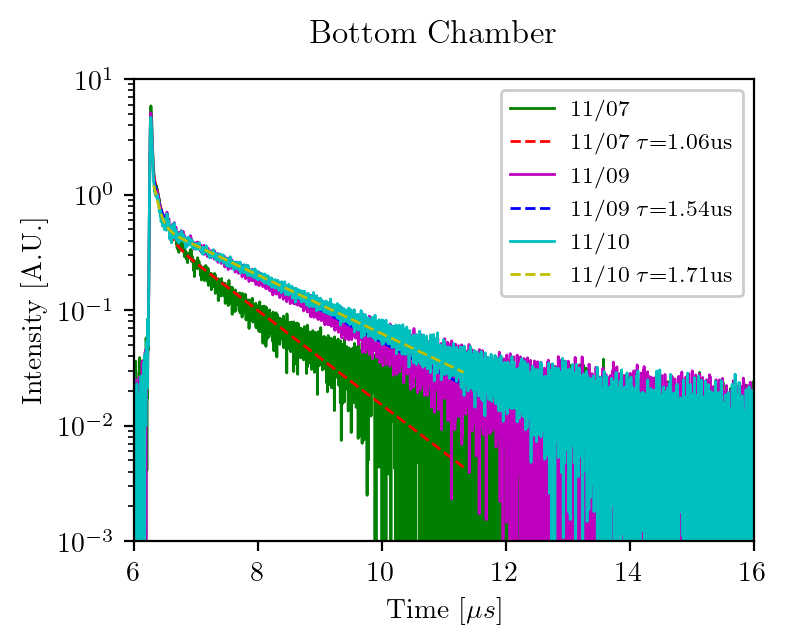

In [22]:
colors = ['g', 'm', 'c']
colors_fit = ['r','b','y']
labels = ['11/07', '11/09', '11/10']
tau_triplet_bot = []
for i,fdc in enumerate(f_deconv_sum_bot):
    dset = ds_bot[i].ch[0]
    t0 = np.argmax(fdc)+int(0.05/dset.sample_step)
    length = int(5/dset.sample_step)
    err = np.std(fdc[:dset.baseline_samples])
    popt,pcov = curve_fit(dset.get_scintillation, dset.time[t0:t0+length], fdc[t0:t0+length], p0=[5, 0.02, 0.5, 1.2, 0.01, 6.25], sigma=[err]*length, maxfev=100000)
    print('{} A_S={:.4f}+/-{:.4f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.4f}+/-{:.4f}  TAU_T={:.4f}+/-{:.4f}us sigma={:.4f}+/-{:.4f}us t0={:.4f}+/-{:.4f}us'.format(labels[i],popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
    tau_triplet_bot.append([popt[3], np.sqrt(pcov[3,3])])
    plt.plot(dset.time, fdc, '{}-'.format(colors[i]), label=labels[i], linewidth=1)
    plt.plot(dset.time[t0:t0+length], dset.get_scintillation(dset.time[t0:t0+length], *popt), '{}--'.format(colors_fit[i]), label=r'{} $\tau$={:.2f}us'.format(labels[i], popt[3]), linewidth=1)
    
plt.legend(loc='upper right')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel('Intensity [A.U.]')
plt.yscale('log')
plt.xlim(6, 16)
plt.ylim(1e-3, 1e1)
plt.suptitle('Bottom Chamber')

## Triplet lifetime evolution

(0.8, 2.0)

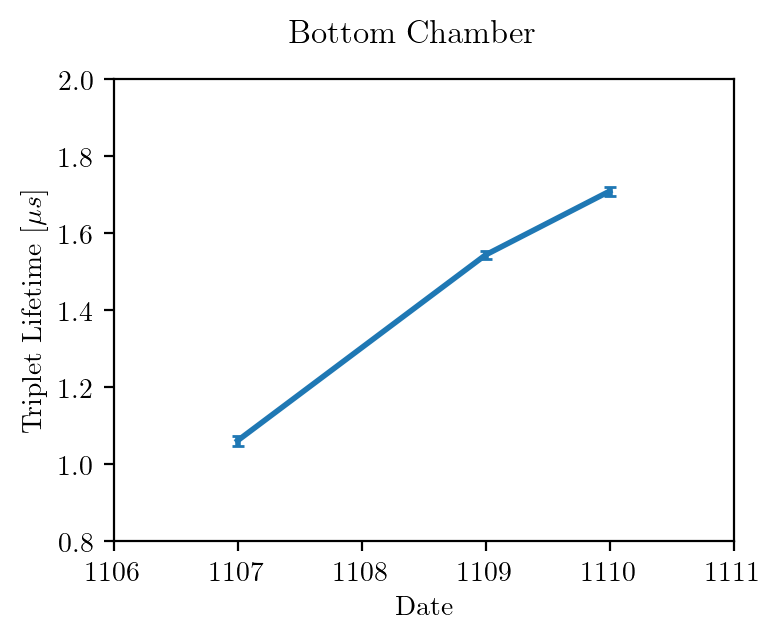

In [32]:
date_bot = [1107, 1109, 1110]
tau_triplet_bot = np.array(tau_triplet_bot)
plt.errorbar(date_bot, tau_triplet_bot[:,0], yerr=tau_triplet_bot[:,1])
plt.xlim(1106, 1111)
plt.xlabel('Date')
plt.ylabel(r'Triplet Lifetime [$\mu s$]')
plt.suptitle('Bottom Chamber')
plt.ylim(0.8, 2.0)

# Top 11/08 11/09 11/10 Day

In [24]:
# subdir: 0
dir1108top = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-08/2022-11-08_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_0/'
#subdir: 0-19
dir1109top = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/'
#subdir: 0-19
dir1110top = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/'

In [25]:
ds_top = []
nsubdir = [1,20,20]
# gain = [[T0,T1,T2,T3],[B0,B1,B2,B3]]
gain = [[526.15408, 519.05546, 507.44070, 521.98428], [518.84503, 510.84132, 504.40531, 457.59589]]
for i,dir in enumerate([dir1108top, dir1109top, dir1110top]):
    for j in range(nsubdir[i]):
        subdir = '{}{}/'.format(dir, j)
        print(subdir)
        data = ds.Dataset(subdir, pol=-1, channels=range(4), spe=gain[0])
        for ch in range(4):
            data.ch[ch].path = subdir
            data.ch[ch].read_data()
            data.ch[ch].baseline_subtraction()
            data.ch[ch].get_integral(prompt=0.5, long=5)
            data.ch[ch].get_avgwf(integral_range=[5*data.gain[ch], 100*data.gain[ch]])
            data.ch[ch].clear()
    data.get_summed_integral_pe()
    data.get_fprompt()
    ds_top.append(data)

/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-08/2022-11-08_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_0/0/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/0/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/1/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/2/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/3/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/4/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_top_light_scintillation_coinc_111_c

## Deconvolution channel by channel

ch0 A_S=0.67+/-0.02  TAU_S=0.0258+/-0.0009us  A_T=0.08+/-0.00  TAU_T=1.017+/-0.024us sigma=0.0110+/-0.0003us t0=6.248+/-0.000us
ch1 A_S=1.62+/-0.30  TAU_S=0.0095+/-0.0017us  A_T=0.18+/-0.00  TAU_T=0.559+/-0.013us sigma=0.0131+/-0.0006us t0=6.250+/-0.001us
ch2 A_S=0.73+/-0.02  TAU_S=0.0268+/-0.0007us  A_T=0.09+/-0.00  TAU_T=1.134+/-0.019us sigma=0.0105+/-0.0003us t0=6.246+/-0.000us
ch3 A_S=1.12+/-0.06  TAU_S=0.0145+/-0.0008us  A_T=0.04+/-0.00  TAU_T=1.598+/-0.043us sigma=0.0135+/-0.0003us t0=6.252+/-0.000us
ch0 A_S=0.68+/-0.02  TAU_S=0.0252+/-0.0010us  A_T=0.07+/-0.00  TAU_T=1.184+/-0.027us sigma=0.0107+/-0.0003us t0=6.248+/-0.000us
ch1 A_S=1.33+/-0.15  TAU_S=0.0120+/-0.0014us  A_T=0.17+/-0.00  TAU_T=0.668+/-0.014us sigma=0.0123+/-0.0005us t0=6.249+/-0.001us
ch2 A_S=0.74+/-0.02  TAU_S=0.0263+/-0.0007us  A_T=0.09+/-0.00  TAU_T=1.345+/-0.020us sigma=0.0104+/-0.0002us t0=6.247+/-0.000us
ch3 A_S=1.11+/-0.05  TAU_S=0.0144+/-0.0007us  A_T=0.04+/-0.00  TAU_T=1.819+/-0.041us sigma=0.0133+/-0.00

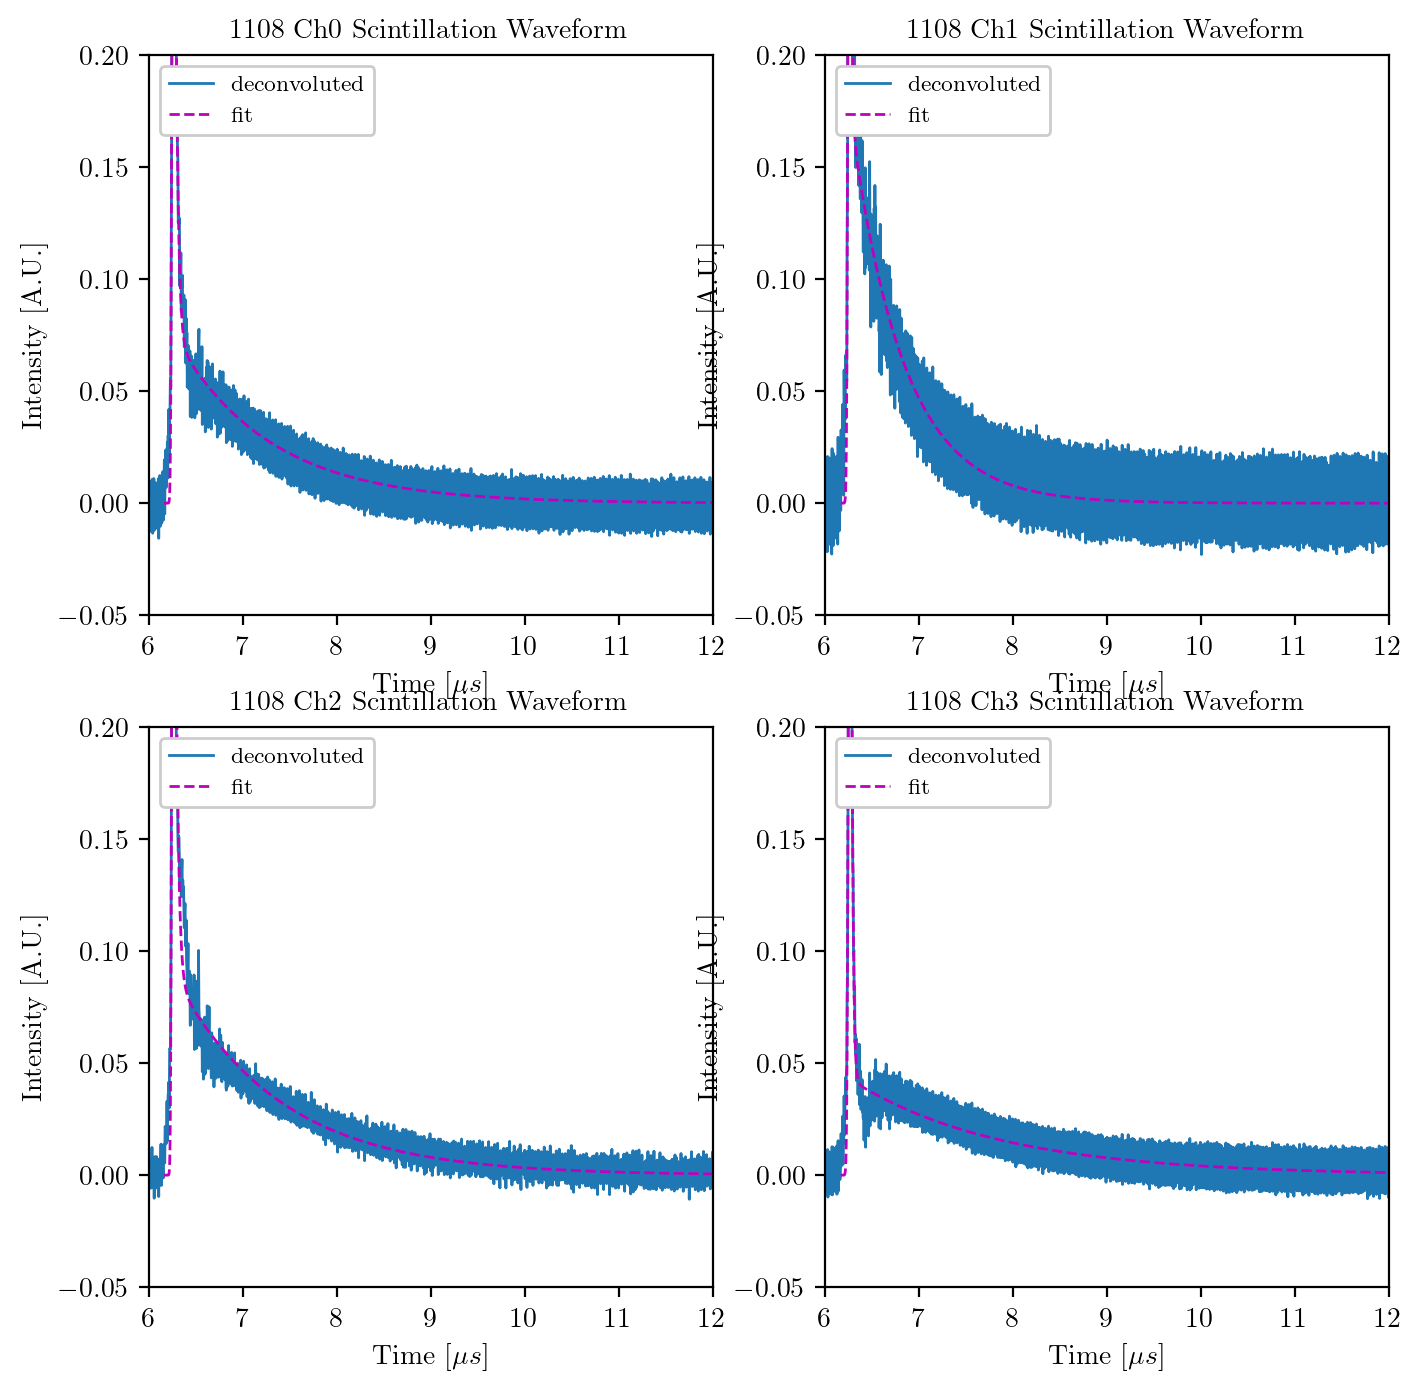

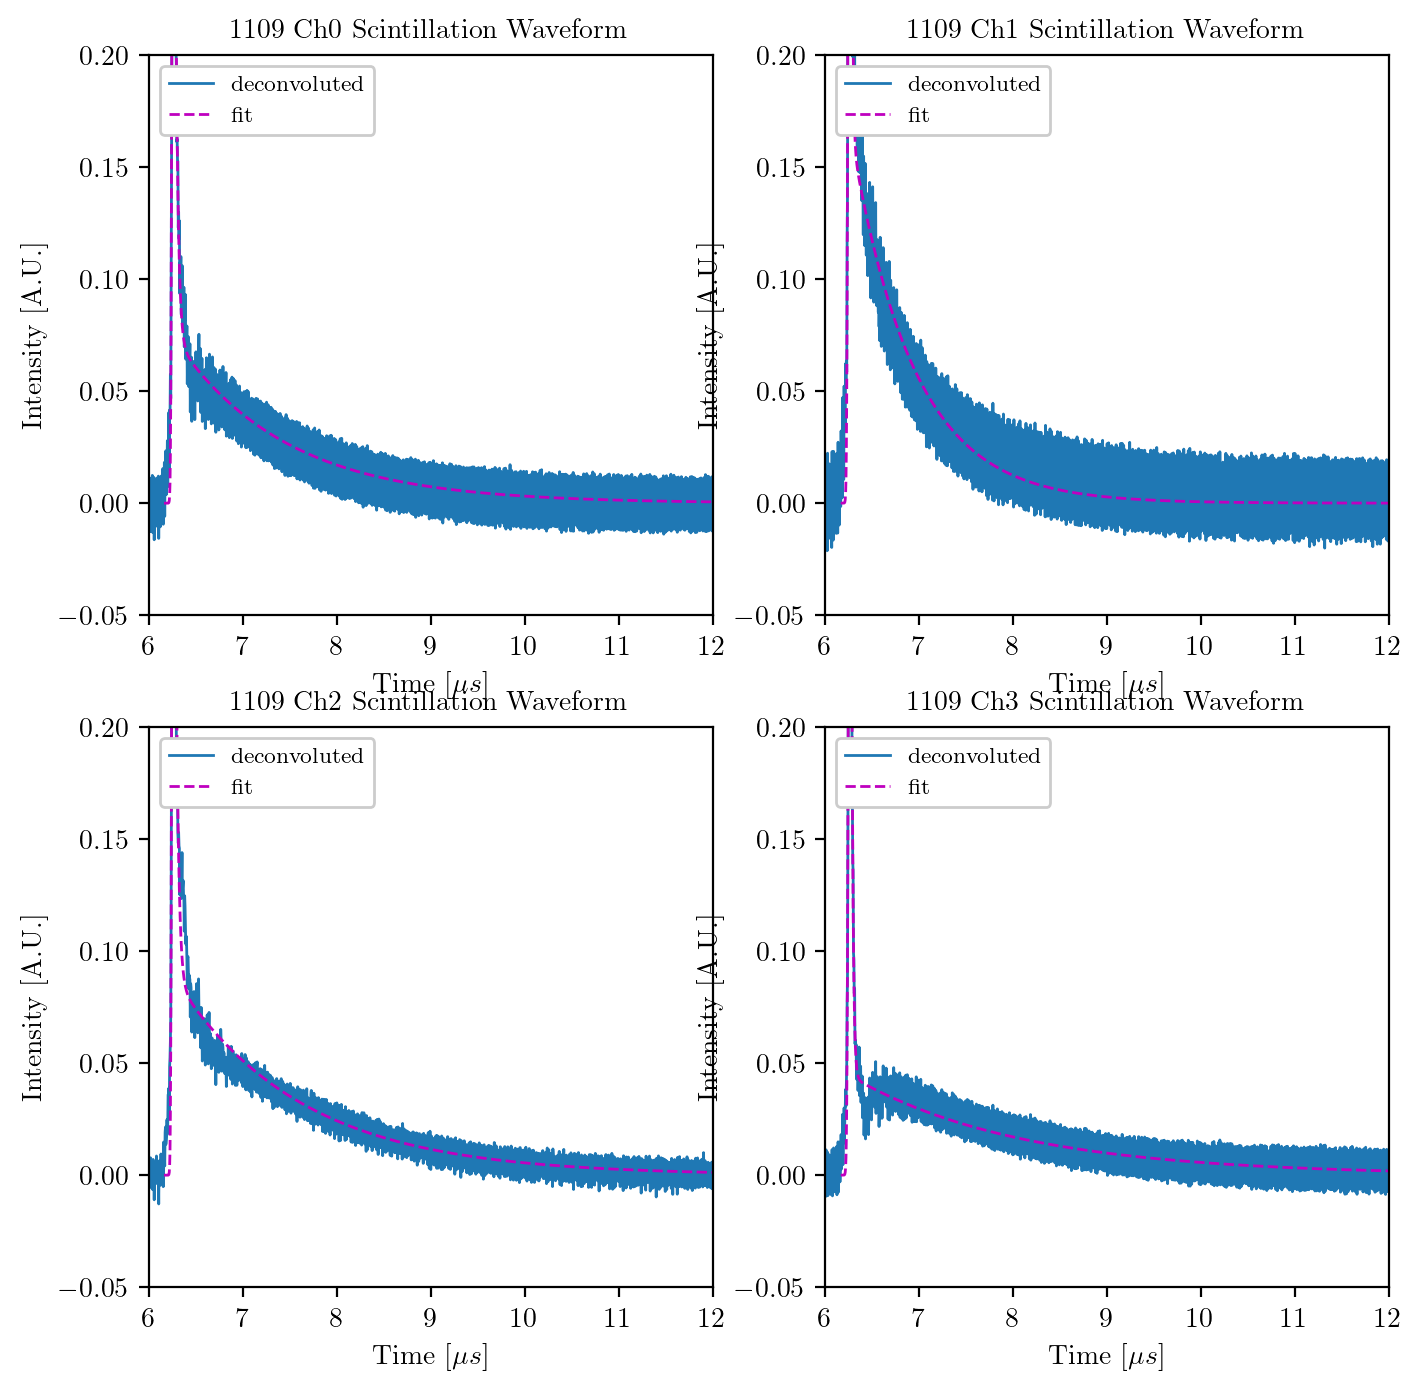

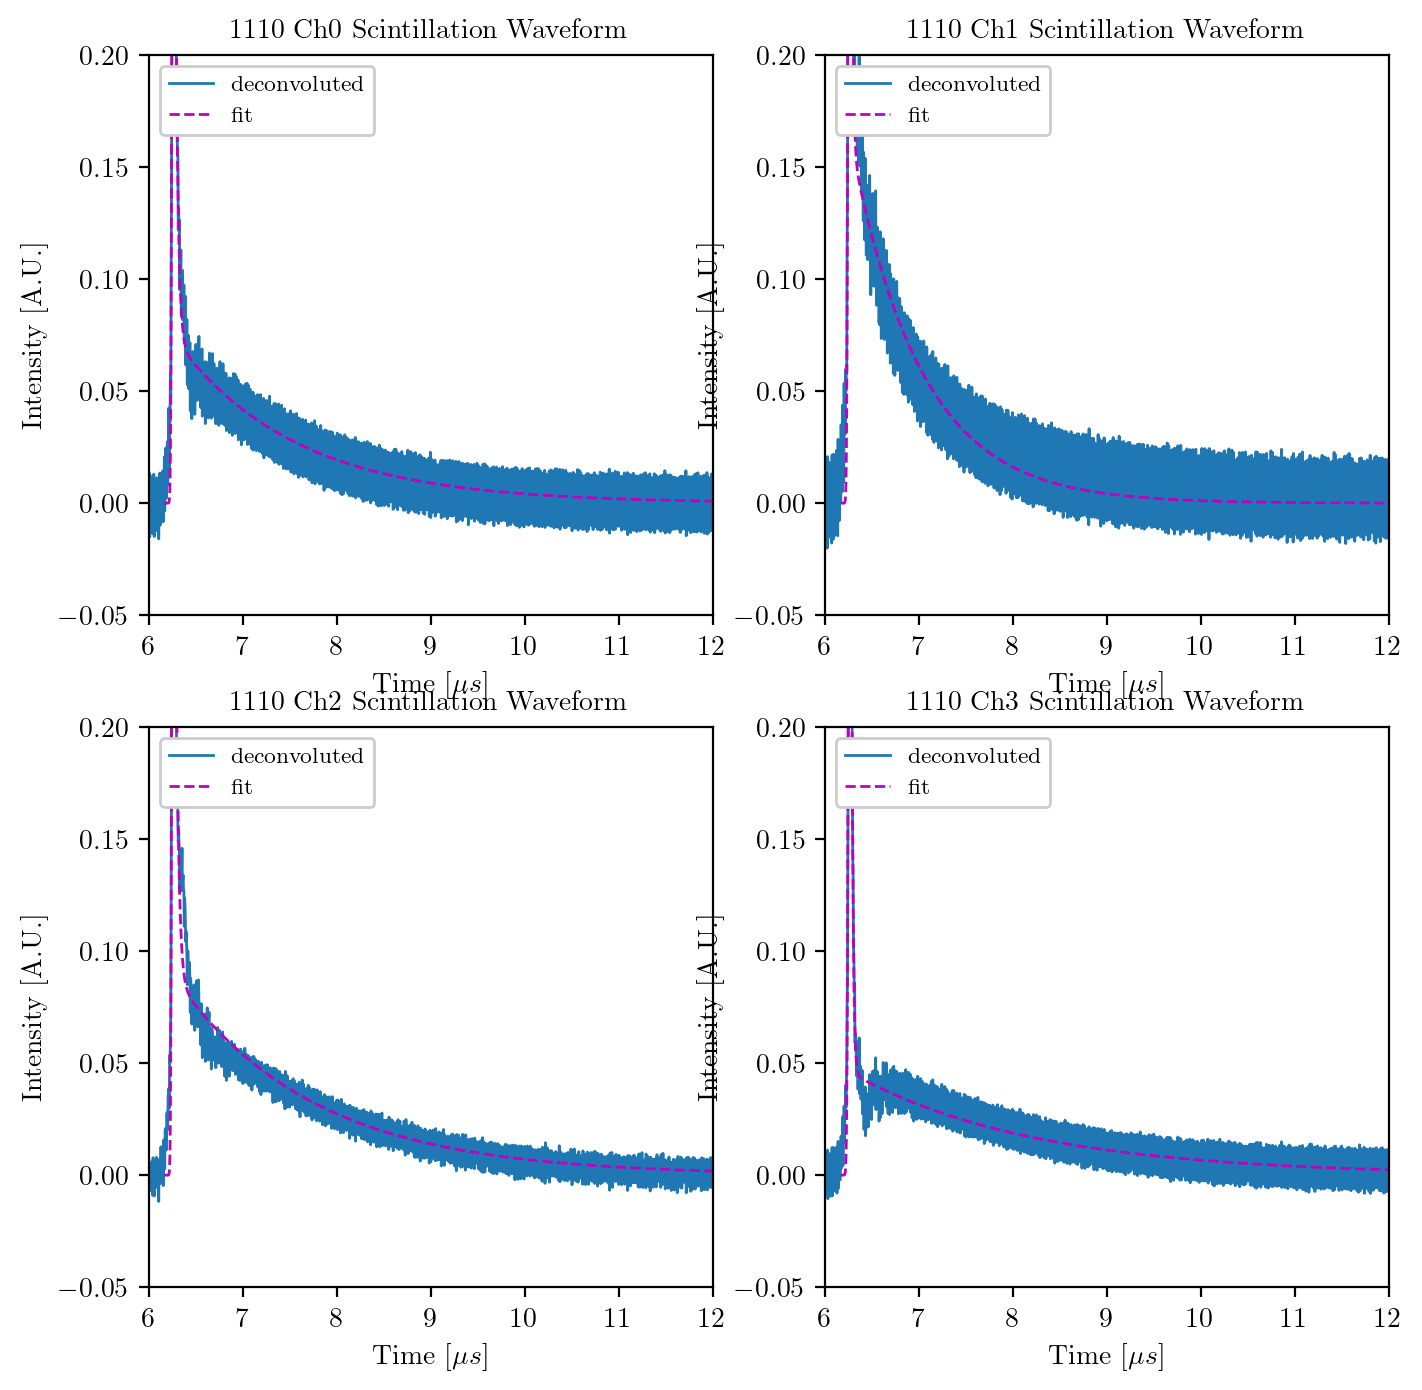

In [26]:
from scipy.fft import fft, ifft
f_deconv_sum_top = []
date = ['1108','1109','1110']
for i,dset in enumerate(ds_top):
    plt.figure(i,figsize=(8,8))
    f_deconv_sum_day = np.zeros(dset.ch[0].samples)
    for ch in range(4):
        dset.ch[ch].set_pulse_pars(*pulse_pars_top[ch])
        ftilde = fft(dset.ch[ch].avgwf)
        a1,tau1,a2,tau2 = dset.ch[ch].get_pulse_pars()
        h = lambda x: a1*np.exp(-x/tau1)+a2*np.exp(-x/tau2)
        htilde = fft(h(dset.ch[ch].time))
        f_deconv = ifft(ftilde/htilde).real
        f_deconv_sum_day += f_deconv
        t0 = np.argmax(f_deconv)-int(0.1/dset.ch[ch].sample_step)
        length = int(6/dset.ch[ch].sample_step)
        err = np.std(dset.ch[ch].avgwf[:dset.ch[ch].baseline_samples])
        popt,pcov = curve_fit(dset.ch[ch].get_scintillation, dset.ch[ch].time[t0:t0+length], f_deconv[t0:t0+length], p0=[1, 0.02, 0.1, 1.2, 0.01, 6.25], sigma=[err]*length, maxfev=100000)
        print('ch{} A_S={:.2f}+/-{:.2f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.2f}+/-{:.2f}  TAU_T={:.3f}+/-{:.3f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(ch,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
        dset.ch[ch].tau_singlet = [popt[1], np.sqrt(pcov[1,1])]
        dset.ch[ch].tau_triplet = [popt[3], np.sqrt(pcov[3,3])]
        plt.subplot(2,2,ch+1)
        plt.plot(dset.ch[ch].time, f_deconv, label='deconvoluted', linewidth=1)
        plt.plot(dset.ch[ch].time[t0:t0+length], dset.ch[ch].get_scintillation(dset.ch[ch].time[t0:t0+length], *popt), "m--", label='fit', linewidth=1)
        plt.title('{} Ch{} Scintillation Waveform'.format(date[i],ch))
        plt.ylabel('Intensity [A.U.]')
        plt.xlabel(r'Time [$\mu s$]')
        plt.legend()
        # plt.yscale('log')
        # plt.ylim(1e-3, 1e1)
        plt.ylim(-0.05,0.2)
        plt.xlim(6,12)
    f_deconv_sum_top.append(f_deconv_sum_day)

## Summed scintillation pulse

11/08 A_S=1.0043+/-899326.6717  TAU_S=0.0718+/-0.0040us  A_T=0.3231+/-19324.2780  TAU_T=1.0754+/-0.0130us sigma=0.0014+/-1106.2596us t0=6.2104+/-64309.4207us
11/09 A_S=0.8569+/-417444.8501  TAU_S=0.0746+/-0.0025us  A_T=0.3164+/-9057.9925  TAU_T=1.2691+/-0.0093us sigma=0.0048+/-2258.3995us t0=6.2191+/-36331.2317us
11/10 A_S=0.8778+/-378628.3585  TAU_S=0.0750+/-0.0023us  A_T=0.3194+/-7452.4910  TAU_T=1.3867+/-0.0090us sigma=0.0011+/-400.5032us t0=6.2178+/-32350.1974us


/home/as111/sipm-analysis/sipm/sipm.py:25: RuntimeWarning: overflow encountered in exp
  return a*np.exp(sigma**2/2/tau**2)*np.exp(-(t-t0)/tau)*(1+erf((t-t0-sigma**2/tau)/sigma/np.sqrt(2)))/2
/home/as111/sipm-analysis/sipm/sipm.py:317: RuntimeWarning: invalid value encountered in add
  return pulse_jitter(t, a_s, tau_s, sigma, t0) + pulse_jitter(t, a_t, tau_t, sigma, t0)


Text(0.5, 0.98, 'Top Chamber')

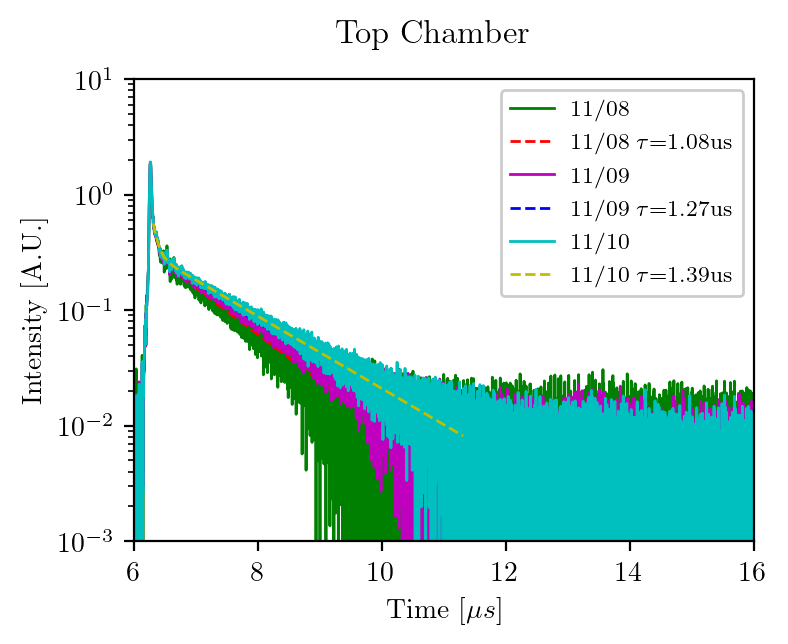

In [29]:
colors = ['g', 'm', 'c']
colors_fit = ['r','b','y']
labels = ['11/08', '11/09', '11/10']
tau_triplet_top = []
for i,fdc in enumerate(f_deconv_sum_top):
    dset = ds_top[i].ch[0]
    t0 = np.argmax(fdc)+int(0.05/dset.sample_step)
    length = int(5/dset.sample_step)
    err = np.std(fdc[:dset.baseline_samples])
    popt,pcov = curve_fit(dset.get_scintillation, dset.time[t0:t0+length], fdc[t0:t0+length], p0=[5, 0.02, 0.5, 1.2, 0.01, 6.25], sigma=[err]*length, maxfev=100000)
    print('{} A_S={:.4f}+/-{:.4f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.4f}+/-{:.4f}  TAU_T={:.4f}+/-{:.4f}us sigma={:.4f}+/-{:.4f}us t0={:.4f}+/-{:.4f}us'.format(labels[i],popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
    tau_triplet_top.append([popt[3], np.sqrt(pcov[3,3])])
    plt.plot(dset.time, fdc, '{}-'.format(colors[i]), label=labels[i], linewidth=1)
    plt.plot(dset.time[t0:t0+length], dset.get_scintillation(dset.time[t0:t0+length], *popt), '{}--'.format(colors_fit[i]), label=r'{} $\tau$={:.2f}us'.format(labels[i], popt[3]), linewidth=1)
    
plt.legend(loc='upper right')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel('Intensity [A.U.]')
plt.yscale('log')
plt.xlim(6, 16)
plt.ylim(1e-3, 1e1)
plt.suptitle('Top Chamber')

## Triplet lifetime evolution

Text(0.5, 0.98, 'Top Chamber')

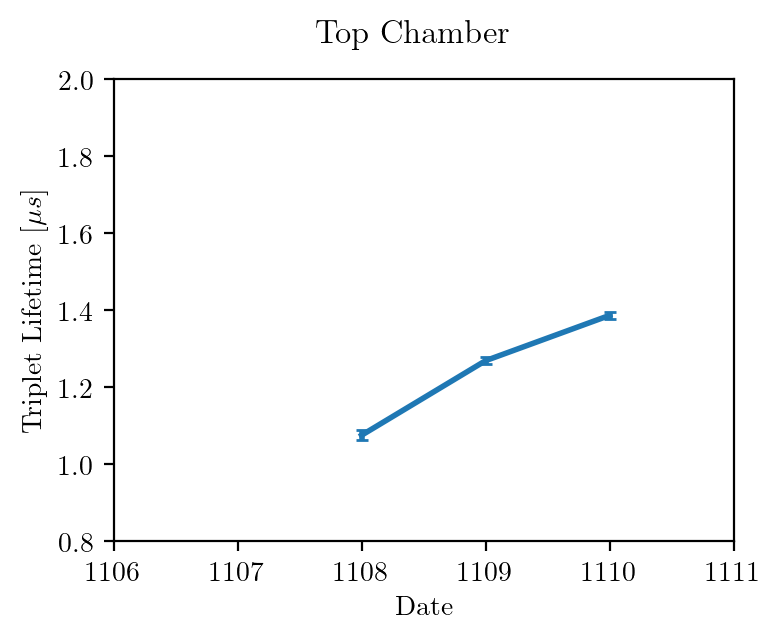

In [35]:
date_top = [1108, 1109, 1110]
tau_triplet_top = np.array(tau_triplet_top)
plt.errorbar(date_top, tau_triplet_top[:,0], yerr=tau_triplet_top[:,1])
plt.xlim(1106, 1111)
plt.xlabel('Date')
plt.ylabel(r'Triplet Lifetime [$\mu s$]')
plt.ylim(0.8, 2.0)
plt.suptitle('Top Chamber')

## Triplet lifetime evolution (Top vs Bottom)

(0.8, 2.0)

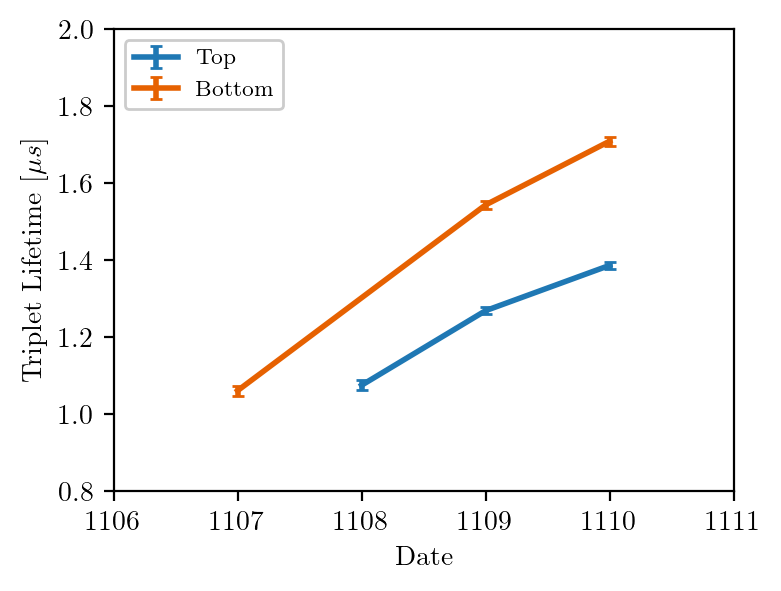

In [33]:
date_top = [1108, 1109, 1110]
tau_triplet_top = np.array(tau_triplet_top)
plt.errorbar(date_top, tau_triplet_top[:,0], yerr=tau_triplet_top[:,1], label='Top')
plt.errorbar(date_bot, tau_triplet_bot[:,0], yerr=tau_triplet_bot[:,1], label='Bottom')
plt.legend()
plt.xlim(1106, 1111)
plt.xlabel('Date')
plt.ylabel(r'Triplet Lifetime [$\mu s$]')
plt.ylim(0.8, 2.0)

# Scintillation data bottom 1107

In [2]:
# dir1007 = "/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-07/"
# subdir1007 = ["2022-10-07_volt_65_pos_top_light_scint_coinc_111",
#               "2022-10-07_volt_67_pos_top_light_scint_coinc_111",
#               "2022-10-07_volt_69_pos_top_light_scint_coinc_111",
#               "2022-10-07_volt_71_pos_top_light_scint_coinc_111",
#               "2022-10-07_volt_73_pos_top_light_scint_coinc_111",
#               "2022-10-07_volt_75_pos_top_light_scint_coinc_111"]
# dscrp1007 = ["65V", "67V", "69V", "71V", "73V", "75V"]
# bias = [65, 67, 69, 71, 73, 75]

# dir1104_bg = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-04/2022-11-04_volt_70_pos_bottom_light_scintillation_coinc_111_cond_no_gamma'
# dir1104_cs = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-04/2022-11-04_volt_70_pos_bottom_light_scintillation_coinc_111_cond_with_gamma'

dir1107_bkg = []
dir1107_gamma = []
for i in range(6):
    dir1107_bkg.append('/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_no_gamma_purification_{}'.format(i+1))
    dir1107_gamma.append('/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_purification_{}'.format(i+1))


In [3]:
ds1107_bkg = []
ds1107_gamma = []
for i,subdir in enumerate(dir1107_bkg+dir1107_gamma):
    data = ds.Dataset('', pol=-1, channels=range(4), spe=[518.84503, 510.84132, 504.40531, 457.59589])
    for j in range(10):
        data.path = "{}/{}/".format(subdir, j)
        if j<=6 or i!=4:
            for ch in range(4):
                data.ch[ch].path = data.path
                data.ch[ch].read_data()
                data.ch[ch].baseline_subtraction()
                data.ch[ch].get_integral(prompt=0.5, long=5)
                data.ch[ch].get_avgwf(integral_range=[5*data.gain[ch], 20*data.gain[ch]])
                data.ch[ch].clear()
    data.get_summed_integral_pe()
    data.get_fprompt()
    if i<len(dir1107_bkg):
        ds1107_bkg.append(data)
    else:
        ds1107_gamma.append(data)

## $f_{\rm prompt}$ distribution
Prompt integral = $0.5~\rm{\mu s}$ integrated charge
Total integral = $5~\rm{\mu s}$ integrated charge

Text(0.5, 0.98, 'Cs-137 + Backgrounds')

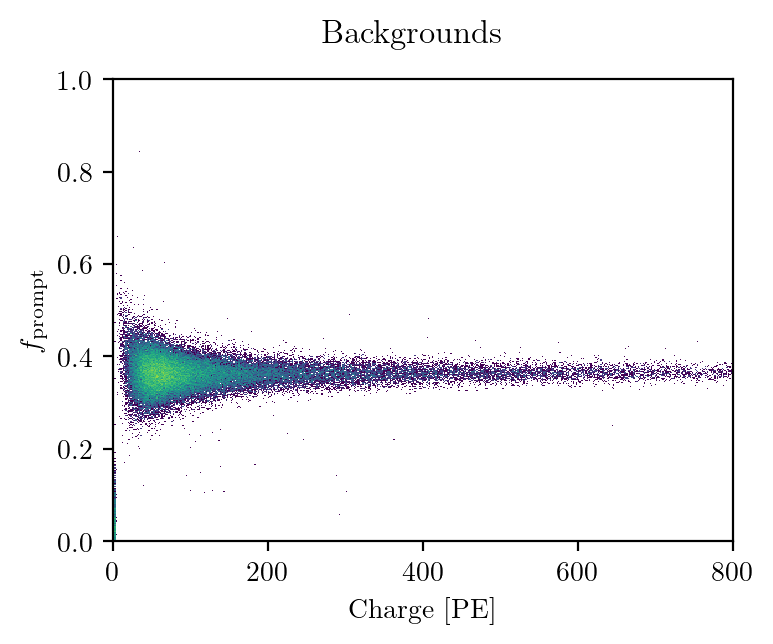

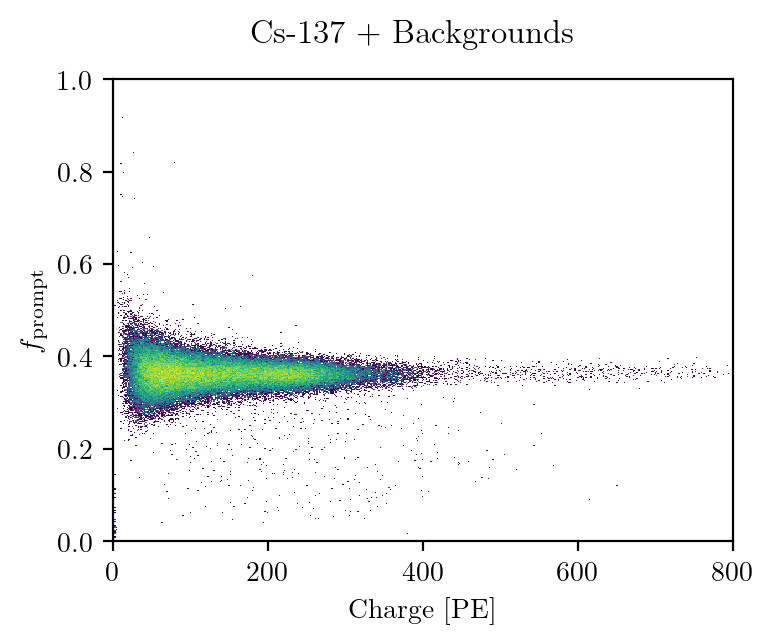

In [4]:
import matplotlib.colors as colors
plt.figure(0)
dset = ds1107_bkg[0]
plt.hist2d(dset.summed_integral_pe, dset.fprompt, bins=[500,500], range=[[0,800],[0,1]], norm = colors.LogNorm())
plt.xlabel('Charge [PE]')
plt.ylabel(r'$f_{\rm prompt}$')
plt.suptitle('Backgrounds')
plt.figure(1)
dset = ds1107_gamma[0]
plt.hist2d(dset.summed_integral_pe, dset.fprompt, bins=[500,500], range=[[0,800],[0,1]], norm = colors.LogNorm())
plt.xlabel('Charge [PE]')
plt.ylabel(r'$f_{\rm prompt}$')
plt.suptitle('Cs-137 + Backgrounds')

## Spectrum of $5~\rm{\mu s}$ integrated charge

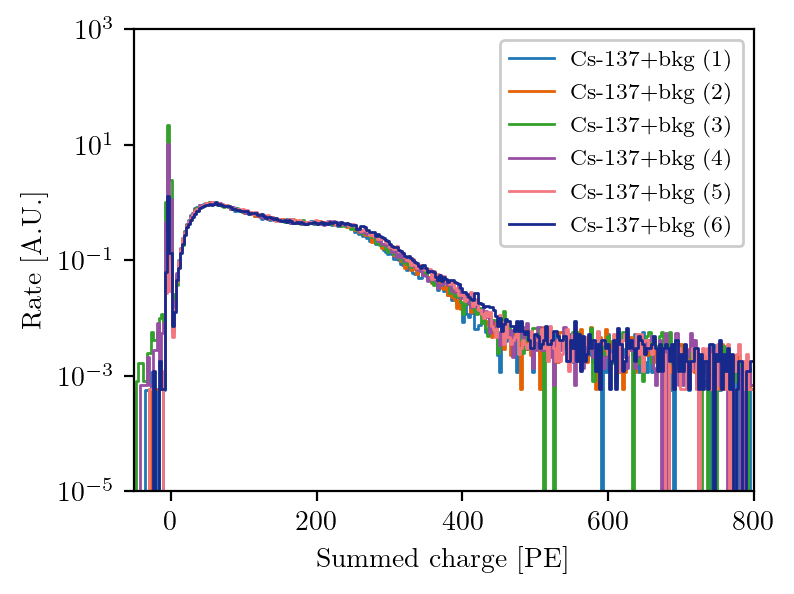

In [5]:
xmin = -50
xmax = 800
nbins = 300
bin_width = (xmax-xmin)/nbins
labels = []
for i in range(len(ds1107_gamma)):
    labels.append('Cs-137+bkg ({})'.format(i+1))
plt.figure()
hist = []
for i in range(len(ds1107_gamma)):
    dset = ds1107_gamma[i]
    h,hx = np.histogram(dset.summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
    h = h/np.max(h[20:])
    #h = h/ds.ch[0].cumulative_time/bin_width
    hist.append(h)
    plt.step(hx[:-1], h, label=labels[i], linewidth=1)
# plt.step(hx[:-1], hist[1]-hist[0], label='difference', linewidth=1)
plt.yscale('log')
plt.legend(loc='upper right')
plt.xlim(xmin, xmax)
plt.ylim(1e-5, 1e3)
plt.xlabel('Summed charge [PE]')
plt.ylabel('Rate [A.U.]')
plt.show()

## Triplet lifetime

ch0 A_S=322.730+/-26.309  TAU_S=0.0465+/-0.0033us  A_T=36.947+/-0.042  TAU_T=0.7764+/-0.0007us
ch1 A_S=134.100+/-0.671  TAU_S=0.1818+/-0.0012us  A_T=25.111+/-0.135  TAU_T=1.5921+/-0.0067us
ch2 A_S=78440380.465+/-287283630017.104  TAU_S=0.0000+/-0.0014us  A_T=28.657+/-0.107  TAU_T=1.2271+/-0.0033us
ch3 A_S=117588994.690+/-661372556233.377  TAU_S=0.0000+/-0.0016us  A_T=18.205+/-0.105  TAU_T=2.0668+/-0.0106us
ch0 A_S=325.158+/-26.865  TAU_S=0.0465+/-0.0034us  A_T=37.959+/-0.042  TAU_T=0.7831+/-0.0007us
ch1 A_S=136.880+/-0.699  TAU_S=0.1788+/-0.0012us  A_T=26.648+/-0.137  TAU_T=1.5691+/-0.0064us
ch2 A_S=80138930.241+/-297148586238.548  TAU_S=0.0000+/-0.0014us  A_T=30.043+/-0.104  TAU_T=1.2373+/-0.0031us
ch3 A_S=110520814.888+/-663988908151.585  TAU_S=0.0000+/-0.0018us  A_T=19.186+/-0.120  TAU_T=2.0238+/-0.0112us
ch0 A_S=220.277+/-12.922  TAU_S=0.0498+/-0.0026us  A_T=27.432+/-0.034  TAU_T=0.8134+/-0.0008us
ch1 A_S=95.401+/-0.502  TAU_S=0.1888+/-0.0013us  A_T=18.211+/-0.105  TAU_T=1.6659+/-0

/home/as111/sipm-analysis/sipm/sipm.py:328: RuntimeWarning: overflow encountered in exp
  s3 = self.a1*a_s*tau_s*self.tau1*(np.exp(-(t-t_trg)/tau_s)-np.exp(-(t-t_trg)/self.tau1))/(tau_s-self.tau1)
/home/as111/sipm-analysis/sipm/sipm.py:328: RuntimeWarning: overflow encountered in divide
  s3 = self.a1*a_s*tau_s*self.tau1*(np.exp(-(t-t_trg)/tau_s)-np.exp(-(t-t_trg)/self.tau1))/(tau_s-self.tau1)
/home/as111/sipm-analysis/sipm/sipm.py:329: RuntimeWarning: overflow encountered in exp
  s4 = self.a2*a_s*tau_s*self.tau2*(np.exp(-(t-t_trg)/tau_s)-np.exp(-(t-t_trg)/self.tau2))/(tau_s-self.tau2)


ch3 A_S=78055571.620+/-453716072403.093  TAU_S=0.0000+/-0.0018us  A_T=14.052+/-0.083  TAU_T=2.0783+/-0.0111us
ch0 A_S=280.479+/-21.540  TAU_S=0.0465+/-0.0031us  A_T=32.320+/-0.032  TAU_T=0.8155+/-0.0007us
ch1 A_S=112.227+/-0.577  TAU_S=0.1847+/-0.0013us  A_T=22.376+/-0.119  TAU_T=1.6202+/-0.0068us
ch2 A_S=64533806.923+/-254536319724.779  TAU_S=0.0000+/-0.0016us  A_T=25.005+/-0.095  TAU_T=1.2817+/-0.0036us
ch3 A_S=96539034.769+/-576070698950.002  TAU_S=0.0000+/-0.0017us  A_T=17.096+/-0.097  TAU_T=2.0667+/-0.0105us
ch0 A_S=326.800+/-28.136  TAU_S=0.0463+/-0.0035us  A_T=39.748+/-0.041  TAU_T=0.8027+/-0.0007us
ch1 A_S=81525292.817+/-556907112234.631  TAU_S=0.0000+/-0.0030us  A_T=29.383+/-0.294  TAU_T=1.4945+/-0.0107us
ch2 A_S=78842015.723+/-284353075690.212  TAU_S=0.0000+/-0.0014us  A_T=31.916+/-0.106  TAU_T=1.2250+/-0.0029us
ch3 A_S=112087071.599+/-652349465866.167  TAU_S=0.0000+/-0.0017us  A_T=20.444+/-0.119  TAU_T=2.0113+/-0.0103us
ch0 A_S=325.930+/-25.393  TAU_S=0.0465+/-0.0032us  A_T=

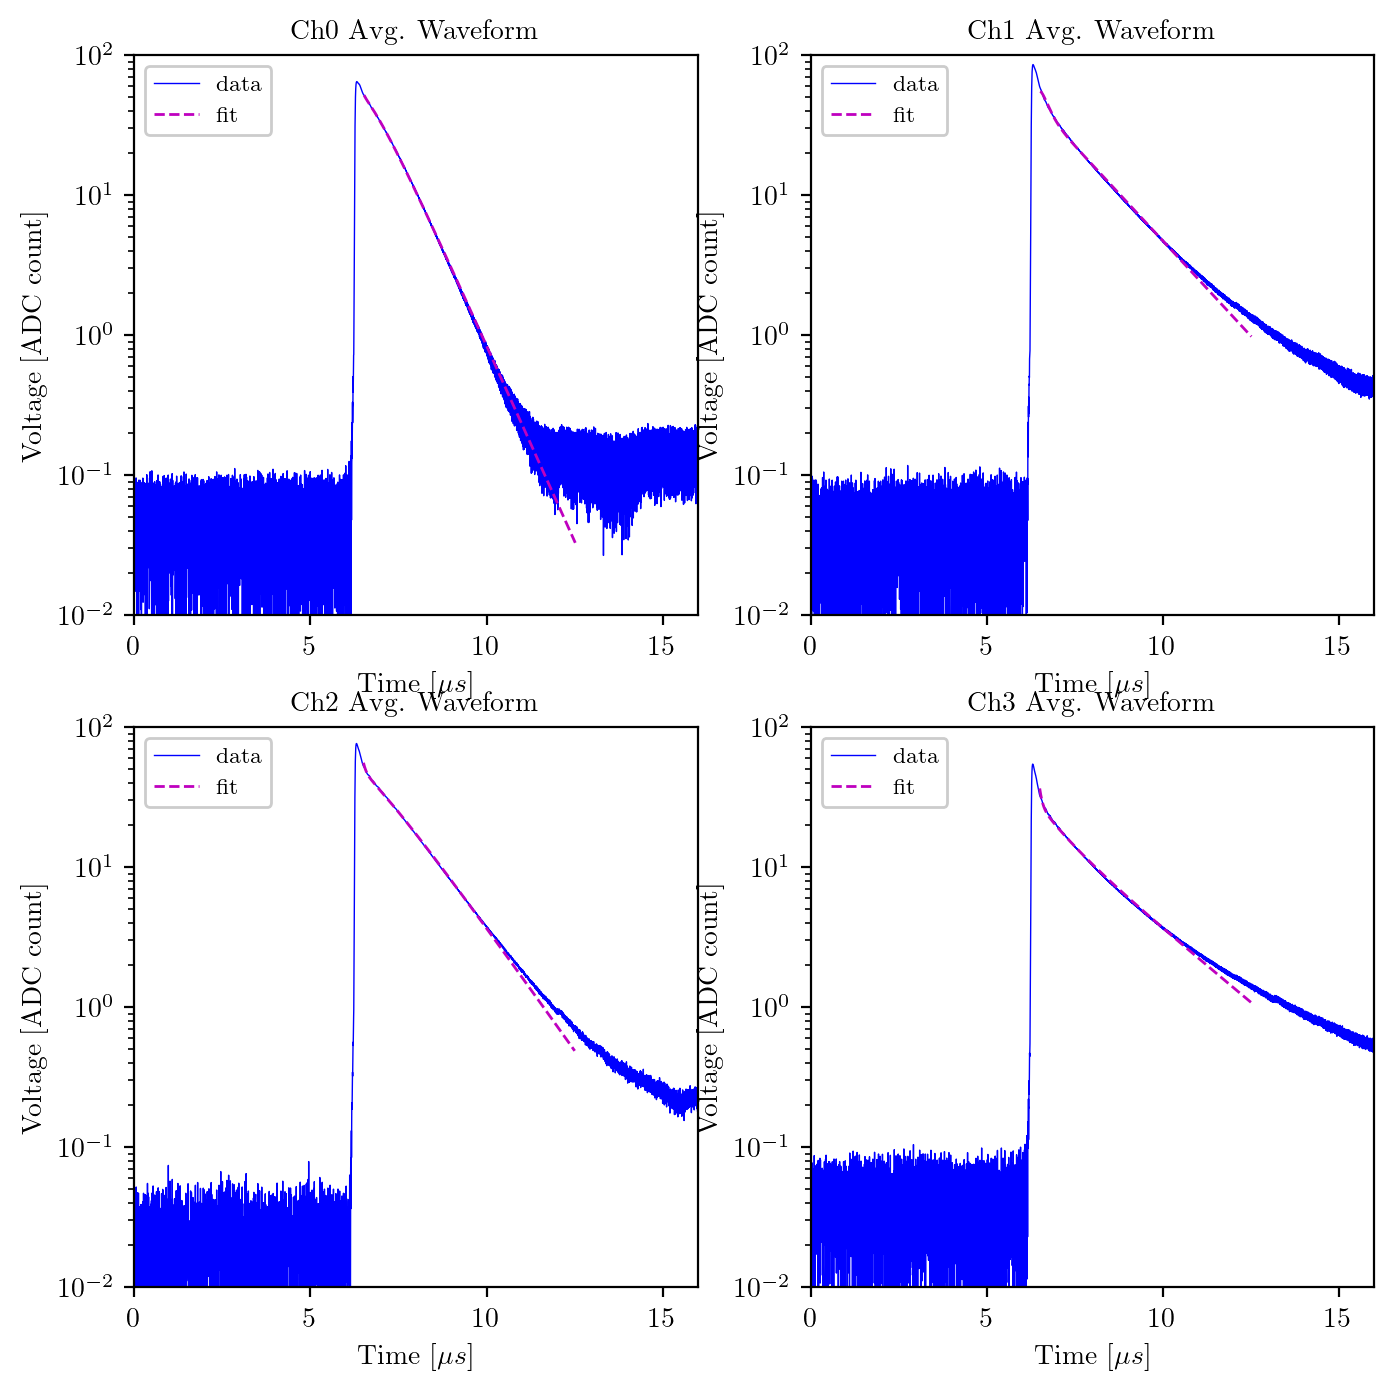

In [6]:
plt.figure(0,figsize=(8,8))
colors = ['r','b','g','m']
A1 = [2.87034549074171, 4.56530440419285, 4.34100691988196, 4.6130995887607]
TAU1 = [0.0444273100352291, 0.101583182633407, 0.07246236377296, 0.0718649983147296]
A2 = [3.02004825336753, 1.03860477405824, 1.42205954757012, 0.783024106669865]
TAU2 = [0.39793842757296, 0.733531780706409, 0.702539511527978, 0.710143874389766]

for i,dset in enumerate(ds1107_gamma):
    for ch in range(4):
        dset.ch[ch].set_pulse_pars(a1=A1[ch], tau1=TAU1[ch], a2=A2[ch], tau2=TAU2[ch])
              
        t0 = dset.ch[ch].trigger_position+int(0.2/dset.ch[ch].sample_step)
        length = int(6/dset.ch[ch].sample_step)
        err = np.std(dset.ch[ch].avgwf[:t0])
        popt,pcov = curve_fit(dset.ch[ch].get_scintillation, dset.ch[ch].time[t0:t0+length], abs(dset.ch[ch].avgwf[t0:t0+length]), p0=[300, 0.05, 40, 1.2], sigma=[err]*length, maxfev=100000)
        print('ch{} A_S={:.3f}+/-{:.3f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.3f}+/-{:.3f}  TAU_T={:.4f}+/-{:.4f}us'.format(ch,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3])))
        dset.ch[ch].tau_singlet = [popt[1], np.sqrt(pcov[1,1])]
        dset.ch[ch].tau_triplet = [popt[3], np.sqrt(pcov[3,3])]
        if i==0:
            plt.subplot(2,2,ch+1)
            plt.plot(dset.ch[ch].time, abs(dset.ch[ch].avgwf), "b-", label='data', linewidth=0.5)
            plt.plot(dset.ch[ch].time[t0:t0+length], dset.ch[ch].get_scintillation(dset.ch[ch].time[t0:t0+length], *popt), "m--", label='fit', linewidth=1.0)
        
for ch in range(4):
    plt.subplot(2,2,ch+1)
    plt.title('Ch{} Avg. Waveform'.format(ch))
    plt.ylabel('Voltage [ADC count]')
    plt.xlabel(r'Time [$\mu s$]')
    plt.legend()
    plt.xlim(0,16)
    plt.ylim(1e-2, 100)
    plt.yscale('log')

# plt.figure(1, figsize=(3,3))
# for ch in range(4):
#     plt.errorbar(np.arange(5), [dset_.ch[ch].tau_triplet[0] for dset_ in ds1006]+[dset.ch[ch].tau_triplet[0]], yerr=[dset_.ch[ch].tau_triplet[1] for dset_ in ds1006]+[dset.ch[ch].tau_triplet[1]], label='ch{}'.format(ch))
# plt.xlim(-1, 5)
# plt.ylim(1, 1.7)
# plt.legend()
# plt.ylabel(r'Triplet lifetime [$\mu s$]')
# plt.xticks(np.arange(5),labels=dscrp1006+['10-07'])

In [8]:
# bottom tile gain 65V
# 
# top tile gain 65V
# [526.15408, 519.05546, 507.44070, 521.98428]

dir1107_on = []
#dir1108_on = []
for i in range(16):
    dir1107_on.append('/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_purification_overnight/{}/'.format(i))
    #dir1108_on.append('/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-08/2022-11-08_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_overnight/{}/'.format(i))    
ds1107_on = []
#ds1108_on = []
for i,subdir in enumerate(dir1107_on):
    data = ds.Dataset('', pol=-1, channels=range(4), spe=[518.84503, 510.84132, 504.40531, 457.59589])
    for ch in range(4):
        print(subdir)
        data.ch[ch].path = subdir
        data.ch[ch].read_data()
        data.ch[ch].baseline_subtraction()
        data.ch[ch].get_integral(prompt=0.5, long=5)
        data.ch[ch].get_avgwf(integral_range=[5*data.gain[ch], 20*data.gain[ch]])
        data.ch[ch].clear()
    data.get_summed_integral_pe()
    data.get_fprompt()
    ds1107_on.append(data)

AttributeError: 'Dataset' object has no attribute 'Dataset'

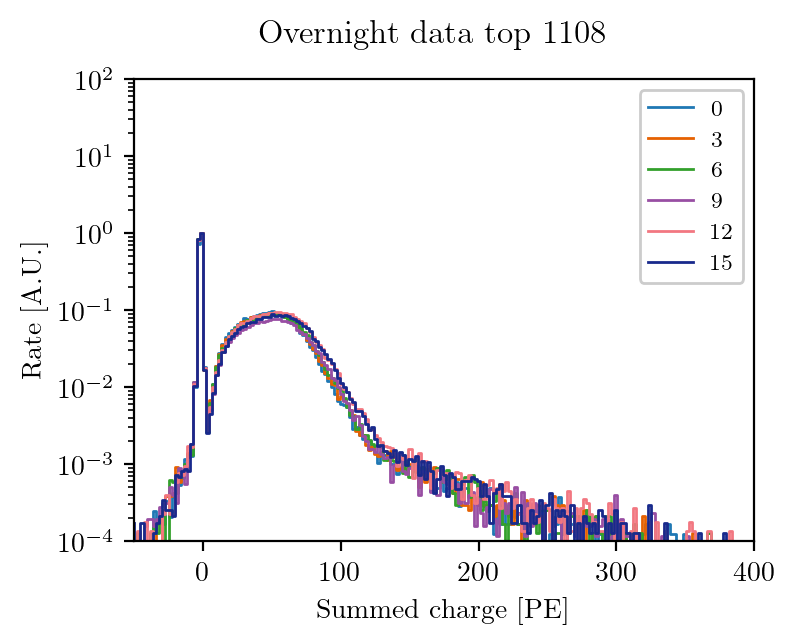

In [7]:
xmin = -50
xmax = 400
nbins = 200
bin_width = (xmax-xmin)/nbins
plt.figure()
hist = []
for i in range(len(ds1107_on)):
    dset = ds1107_on[i]
    h,hx = np.histogram(ds.summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
    h = h/np.max(h[20:])
    #h = h/ds.ch[0].cumulative_time/bin_width
    hist.append(h)
    if i%3==0:
        plt.step(hx[:-1], h, label='{}'.format(i), linewidth=1)
# plt.step(hx[:-1], hist[1]-hist[0], label='difference', linewidth=1)
plt.yscale('log')
plt.legend(loc='upper right')
plt.xlim(xmin, xmax)
plt.ylim(1e-4, 1e2)
plt.xlabel('Summed charge [PE]')
plt.ylabel('Rate [A.U.]')
plt.suptitle('Overnight data bottom 1107')
plt.show()

ch0 A_S=146.892+/-20.856  TAU_S=0.0452+/-0.0056us  A_T=16.736+/-0.029  TAU_T=0.7720+/-0.0010us
ch1 A_S=22592121.931+/-162209357459.665  TAU_S=0.0000+/-0.0036us  A_T=9.664+/-0.115  TAU_T=1.4418+/-0.0120us
ch2 A_S=24802592.049+/-81116918068.951  TAU_S=0.0000+/-0.0013us  A_T=10.237+/-0.032  TAU_T=1.2171+/-0.0028us
ch3 A_S=45120155.267+/-259274452157.150  TAU_S=0.0000+/-0.0018us  A_T=8.592+/-0.055  TAU_T=2.0175+/-0.0113us
ch0 A_S=143.616+/-22.170  TAU_S=0.0452+/-0.0061us  A_T=16.654+/-0.030  TAU_T=0.7794+/-0.0011us
ch1 A_S=22323249.772+/-161786474256.860  TAU_S=0.0000+/-0.0036us  A_T=9.849+/-0.110  TAU_T=1.4385+/-0.0113us
ch2 A_S=24666876.418+/-78375144748.951  TAU_S=0.0000+/-0.0013us  A_T=10.378+/-0.031  TAU_T=1.2146+/-0.0026us
ch3 A_S=43020360.250+/-238473690008.043  TAU_S=0.0000+/-0.0018us  A_T=8.723+/-0.053  TAU_T=2.0059+/-0.0108us
ch0 A_S=139.525+/-20.449  TAU_S=0.0460+/-0.0059us  A_T=16.559+/-0.029  TAU_T=0.7942+/-0.0011us
ch1 A_S=21249214.260+/-153234867809.608  TAU_S=0.0000+/-0.003

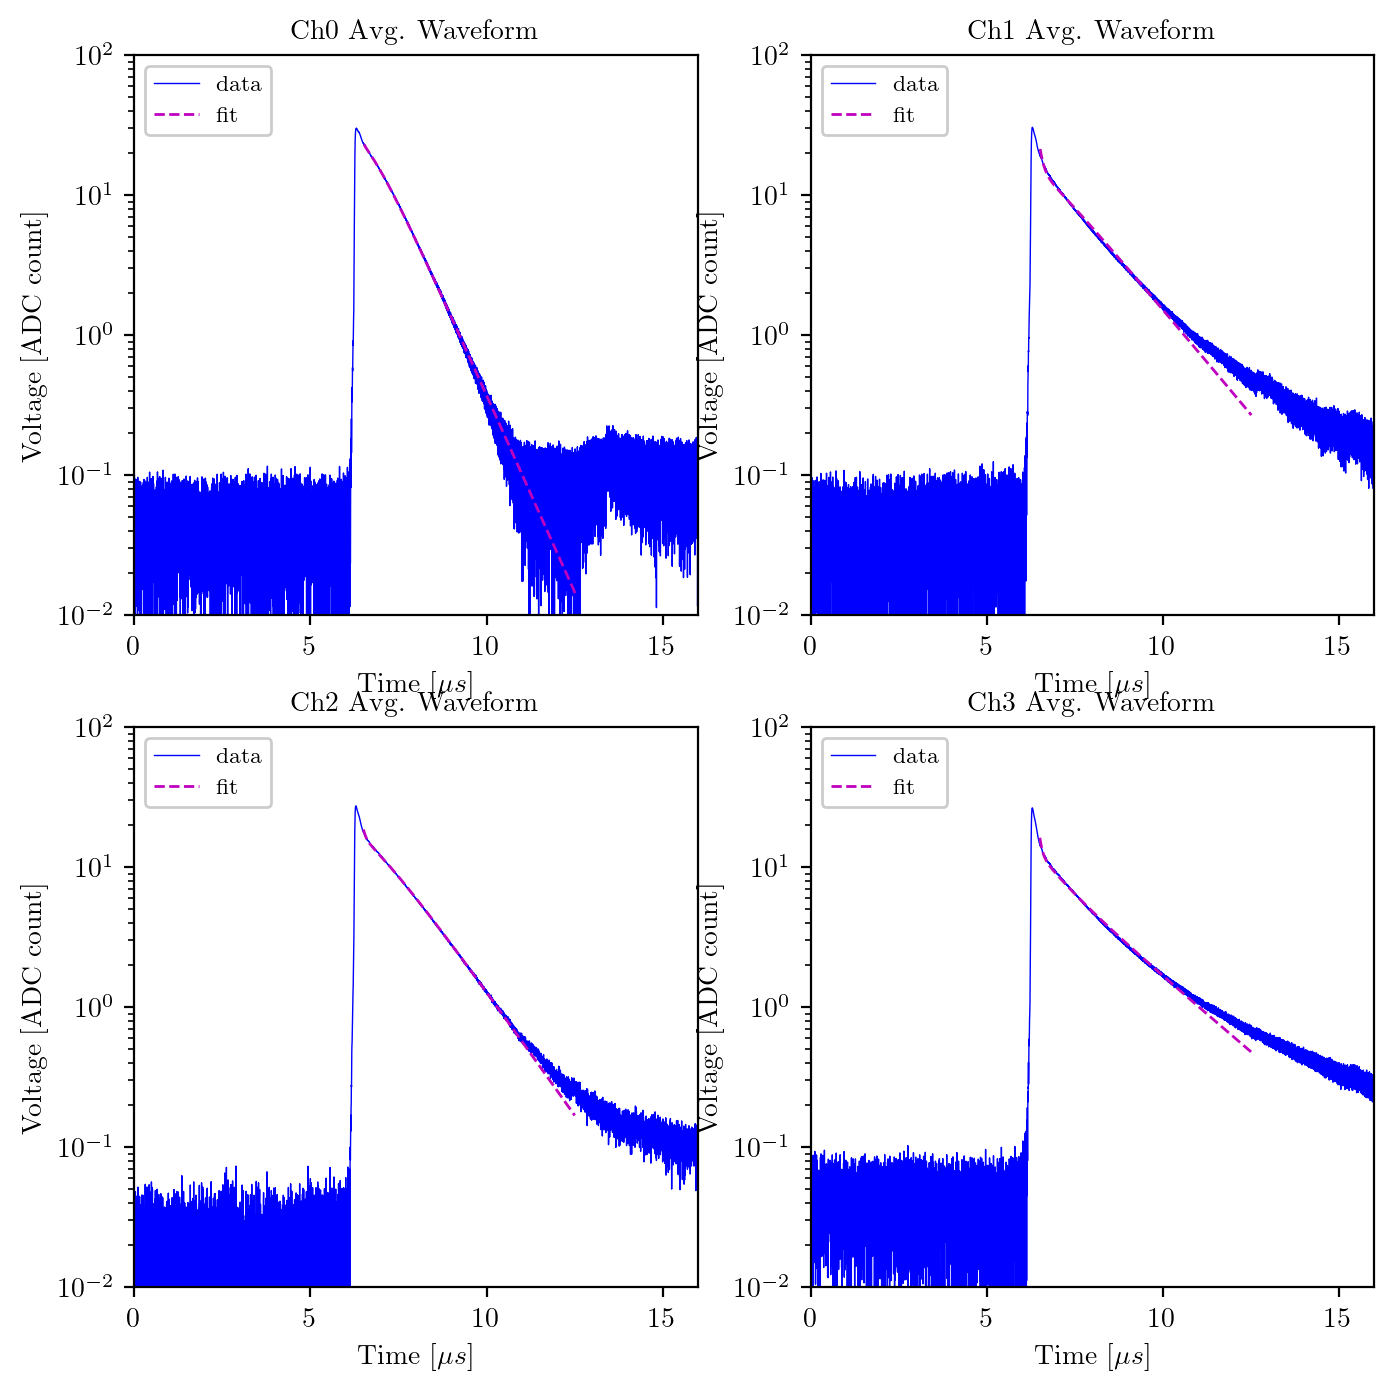

In [9]:
plt.figure(0,figsize=(8,8))
colors = ['r','b','g','m']
# SiPM response parameters bottom 65V
# A1 = [2.87034549074171, 4.56530440419285, 4.34100691988196, 4.6130995887607]
# TAU1 = [0.0444273100352291, 0.101583182633407, 0.07246236377296, 0.0718649983147296]
# A2 = [3.02004825336753, 1.03860477405824, 1.42205954757012, 0.783024106669865]
# TAU2 = [0.39793842757296, 0.733531780706409, 0.702539511527978, 0.710143874389766]
# SiPM response parameters top 65V
A1 = []
TAU1 = []
A2 = []
TAU2 = []

for i,dset in enumerate(ds1108_on):
    for ch in range(4):
        dset.ch[ch].set_pulse_pars(a1=A1[ch], tau1=TAU1[ch], a2=A2[ch], tau2=TAU2[ch])
        t0 = dset.ch[ch].trigger_position+int(0.2/dset.ch[ch].sample_step)
        length = int(6/dset.ch[ch].sample_step)
        err = np.std(dset.ch[ch].avgwf[:t0])
        popt,pcov = curve_fit(dset.ch[ch].get_scintillation, dset.ch[ch].time[t0:t0+length], abs(dset.ch[ch].avgwf[t0:t0+length]), p0=[300, 0.05, 40, 1.2], sigma=[err]*length, maxfev=100000)
        print('ch{} A_S={:.3f}+/-{:.3f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.3f}+/-{:.3f}  TAU_T={:.4f}+/-{:.4f}us'.format(ch,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3])))
        dset.ch[ch].tau_singlet = [popt[1], np.sqrt(pcov[1,1])]
        dset.ch[ch].tau_triplet = [popt[3], np.sqrt(pcov[3,3])]
        if i==0:
            plt.subplot(2,2,ch+1)
            plt.plot(dset.ch[ch].time, abs(dset.ch[ch].avgwf), "b-", label='data', linewidth=0.5)
            plt.plot(dset.ch[ch].time[t0:t0+length], dset.ch[ch].get_scintillation(dset.ch[ch].time[t0:t0+length], *popt), "m--", label='fit', linewidth=1.0)
    
for ch in range(4):
    plt.subplot(2,2,ch+1)
    plt.title('Ch{} Avg. Waveform'.format(ch))
    plt.ylabel('Voltage [ADC count]')
    plt.xlabel(r'Time [$\mu s$]')
    plt.legend()
    plt.xlim(0,16)
    plt.ylim(1e-2, 100)
    plt.yscale('log')

# plt.figure(1, figsize=(3,3))
# for ch in range(4):
#     plt.errorbar(np.arange(5), [dset_.ch[ch].tau_triplet[0] for dset_ in ds1006]+[dset.ch[ch].tau_triplet[0]], yerr=[dset_.ch[ch].tau_triplet[1] for dset_ in ds1006]+[dset.ch[ch].tau_triplet[1]], label='ch{}'.format(ch))
# plt.xlim(-1, 5)
# plt.ylim(1, 1.7)
# plt.legend()
# plt.ylabel(r'Triplet lifetime [$\mu s$]')
# plt.xticks(np.arange(5),labels=dscrp1006+['10-07'])

Text(0.5, 0.98, 'Bottom ch0 Overnight')

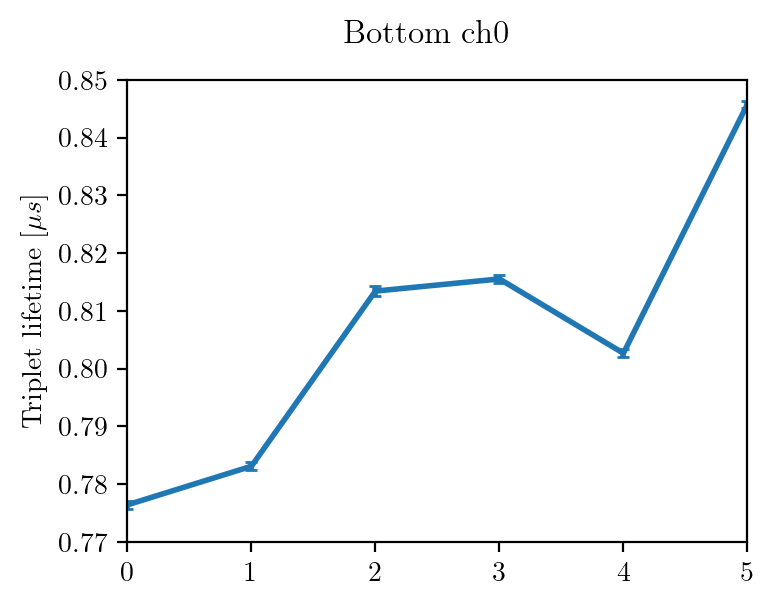

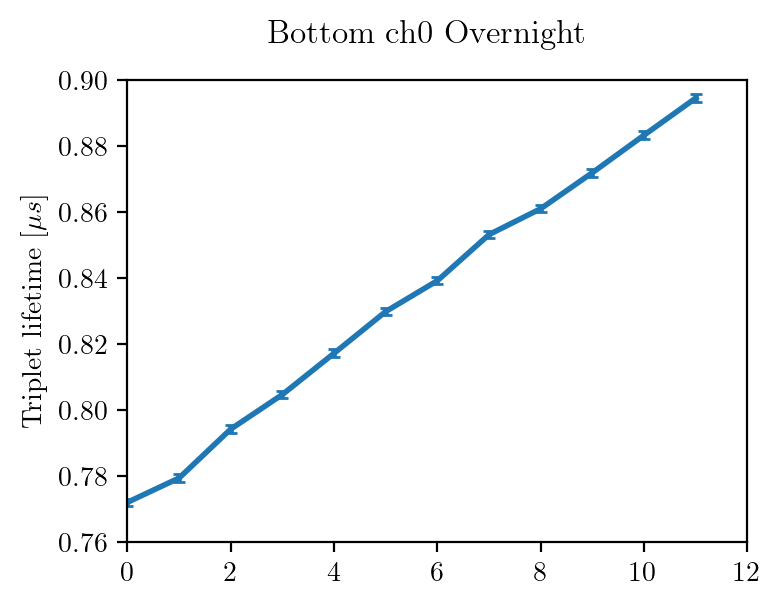

In [22]:
plt.figure(0)
plt.errorbar(np.arange(len(ds1107_gamma)), [dset.ch[0].tau_triplet[0] for dset in ds1107_gamma], yerr=[dset.ch[0].tau_triplet[1] for dset in ds1107_gamma])
plt.ylabel(r'Triplet lifetime [$\mu s$]')
plt.suptitle('Bottom ch0')
plt.figure(1)
plt.errorbar(np.arange(len(ds1107_on)-1), [dset.ch[0].tau_triplet[0] for dset in ds1107_on[:-1]], yerr=[dset.ch[0].tau_triplet[1] for dset in ds1107_on[:-1]])
plt.ylabel(r'Triplet lifetime [$\mu s$]')
plt.suptitle('Bottom ch0 Overnight')

# High-statistics data 1109

In [2]:
dir1109_top = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/'
dir1109_bot = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_high_stat/'


In [3]:
ds1109 = []
gain = [[526.15408, 519.05546, 507.44070, 521.98428], [518.84503, 510.84132, 504.40531, 457.59589]]
for i,dir in enumerate([dir1109_top, dir1109_bot]):
    for j in range(20):
        subdir = '{}{}/'.format(dir, j)
        data = ds.Dataset(subdir, pol=-1, channels=range(4), spe=gain[i])
        for ch in range(4):
            data.ch[ch].path = subdir
            data.ch[ch].read_data()
            data.ch[ch].baseline_subtraction()
            data.ch[ch].get_integral(prompt=0.5, long=5)
            data.ch[ch].get_avgwf(integral_range=[5*data.gain[ch], 100*data.gain[ch]])
            data.ch[ch].clear()
    data.get_summed_integral_pe()
    data.get_fprompt()
    ds1109.append(data)

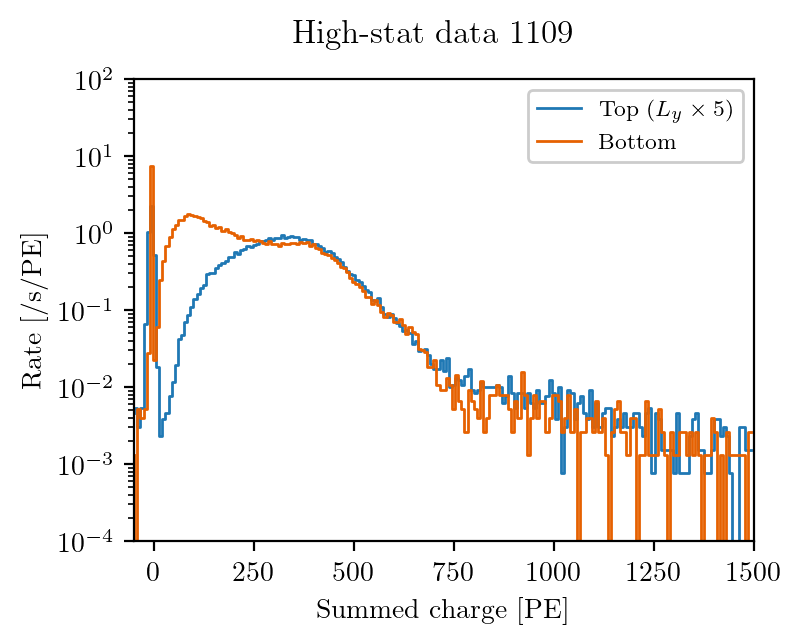

In [4]:
xmin = -50
xmax = 1500
nbins = 200
bin_width = (xmax-xmin)/nbins

plt.figure()
hist = []
#light yield ratio
lyr = 5
ly = [lyr, 1.0]
labels = [r'Top ($L_y\times{}$)'.format(lyr), 'Bottom']
for i,dset in enumerate(ds1109):
    h,hx = np.histogram(dset.summed_integral_pe*ly[i], bins=np.linspace(xmin,xmax,nbins))
    # h = h/np.max(h[20:])
    h = h/dset.ch[0].cumulative_time/bin_width
    hist.append(h)
    plt.step(hx[:-1], h, label=labels[i], linewidth=1)
# plt.step(hx[:-1], hist[1]-hist[0], label='difference', linewidth=1)
plt.yscale('log')
plt.legend(loc='upper right')
plt.xlim(xmin, xmax)
plt.ylim(1e-4, 1e2)
plt.xlabel('Summed charge [PE]')
plt.ylabel('Rate [/s/PE]')
plt.suptitle('High-stat data 1109')
plt.show()

In [5]:
# Read SiPM pulse shape from csv
import csv
pulse_pars_top = []
pulse_pars_bot = []
with open('pulse_parameters_65V.csv') as f:
    r = csv.reader(f)
    line_count = 0
    for row in r:
        if line_count>0:
            if line_count<=4:
                pulse_pars_top.append([float(par) for par in row[1:]])
                print(pulse_pars_top[-1])
            else:
                pulse_pars_bot.append([float(par) for par in row[1:]])
                print(pulse_pars_bot[-1])
        line_count += 1


[4.785269765091801, 0.24465717230046793, 4.073501733077282, 0.019567625094531624]
[1.6673254424459918, 0.47719420237660765, 4.903429623168718, 0.08571027976327786]
[1.7772347297673032, 0.420307822140636, 5.259472382086961, 0.06012379531673089]
[5.46460121203827, 0.27214909992926917, 4.358305910658269, 0.011102848302532735]
[3.159016495606167, 0.3970144047422518, 4.072443314855156, 0.04496687268229123]
[0.9718248355955384, 0.8285785218030871, 5.524493722728364, 0.1028647225158728]
[1.382881398253107, 0.7346785481410949, 5.30060245748518, 0.07496312866265117]
[0.7145097171380426, 0.8118939509327021, 5.570884898422146, 0.0740521372552768]


ch0 A_S=-2.97+/-0.79  TAU_S=0.0335+/-0.0064us  A_T=27.91+/-0.03  TAU_T=1.227+/-0.002us sigma=0.0170+/-0.0003us t0=6.255+/-0.000us
ch1 A_S=-11.27+/-0.13  TAU_S=0.1449+/-0.0029us  A_T=42.16+/-0.08  TAU_T=1.071+/-0.002us sigma=0.0200+/-0.0002us t0=6.255+/-0.000us
ch2 A_S=-58.68+/-5.67  TAU_S=0.0025+/-0.0000us  A_T=24.82+/-0.06  TAU_T=1.587+/-0.005us sigma=0.0155+/-0.0001us t0=6.246+/-0.000us
ch3 A_S=8.29+/-0.37  TAU_S=0.0688+/-0.0035us  A_T=21.59+/-0.04  TAU_T=1.735+/-0.004us sigma=0.0191+/-0.0003us t0=6.256+/-0.000us


/home/as111/sipm-analysis/sipm/sipm.py:25: RuntimeWarning: overflow encountered in multiply
  return a*np.exp(sigma**2/2/tau**2)*np.exp(-(t-t0)/tau)*(1+erf((t-t0-sigma**2/tau)/sigma/np.sqrt(2)))/2
/home/as111/sipm-analysis/sipm/sipm.py:25: RuntimeWarning: invalid value encountered in multiply
  return a*np.exp(sigma**2/2/tau**2)*np.exp(-(t-t0)/tau)*(1+erf((t-t0-sigma**2/tau)/sigma/np.sqrt(2)))/2
/tmp/ipykernel_1173849/3825587994.py:14: RuntimeWarning: invalid value encountered in sqrt
  print('ch{} A_S={:.2f}+/-{:.2f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.2f}+/-{:.2f}  TAU_T={:.3f}+/-{:.3f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(ch,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
/tmp/ipykernel_1173849/3825587994.py:15: RuntimeWarning: invalid value encountered in sqrt
  dset.ch[ch].tau_singlet = [popt[1], np.sqrt(pcov[1,1])]
/tmp/ipykernel_1173849/3825587994.py

ch0 A_S=-10467.53+/-nan  TAU_S=0.9539+/-nanus  A_T=10531.78+/-nan  TAU_T=0.957+/-nanus sigma=0.0140+/-0.0002us t0=6.269+/-0.000us
ch1 A_S=-57.54+/-505.43  TAU_S=0.0017+/-0.0004us  A_T=43.37+/-0.49  TAU_T=2.034+/-0.017us sigma=0.0080+/-0.0015us t0=6.261+/-0.021us
ch2 A_S=-180.55+/-26.15  TAU_S=0.0016+/-0.0000us  A_T=54.97+/-0.15  TAU_T=1.903+/-0.008us sigma=0.0112+/-0.0001us t0=6.257+/-0.000us
ch3 A_S=-3.20+/-182.12  TAU_S=0.0013+/-0.0008us  A_T=53.26+/-0.23  TAU_T=1.785+/-0.011us sigma=0.0108+/-0.0014us t0=6.262+/-0.002us


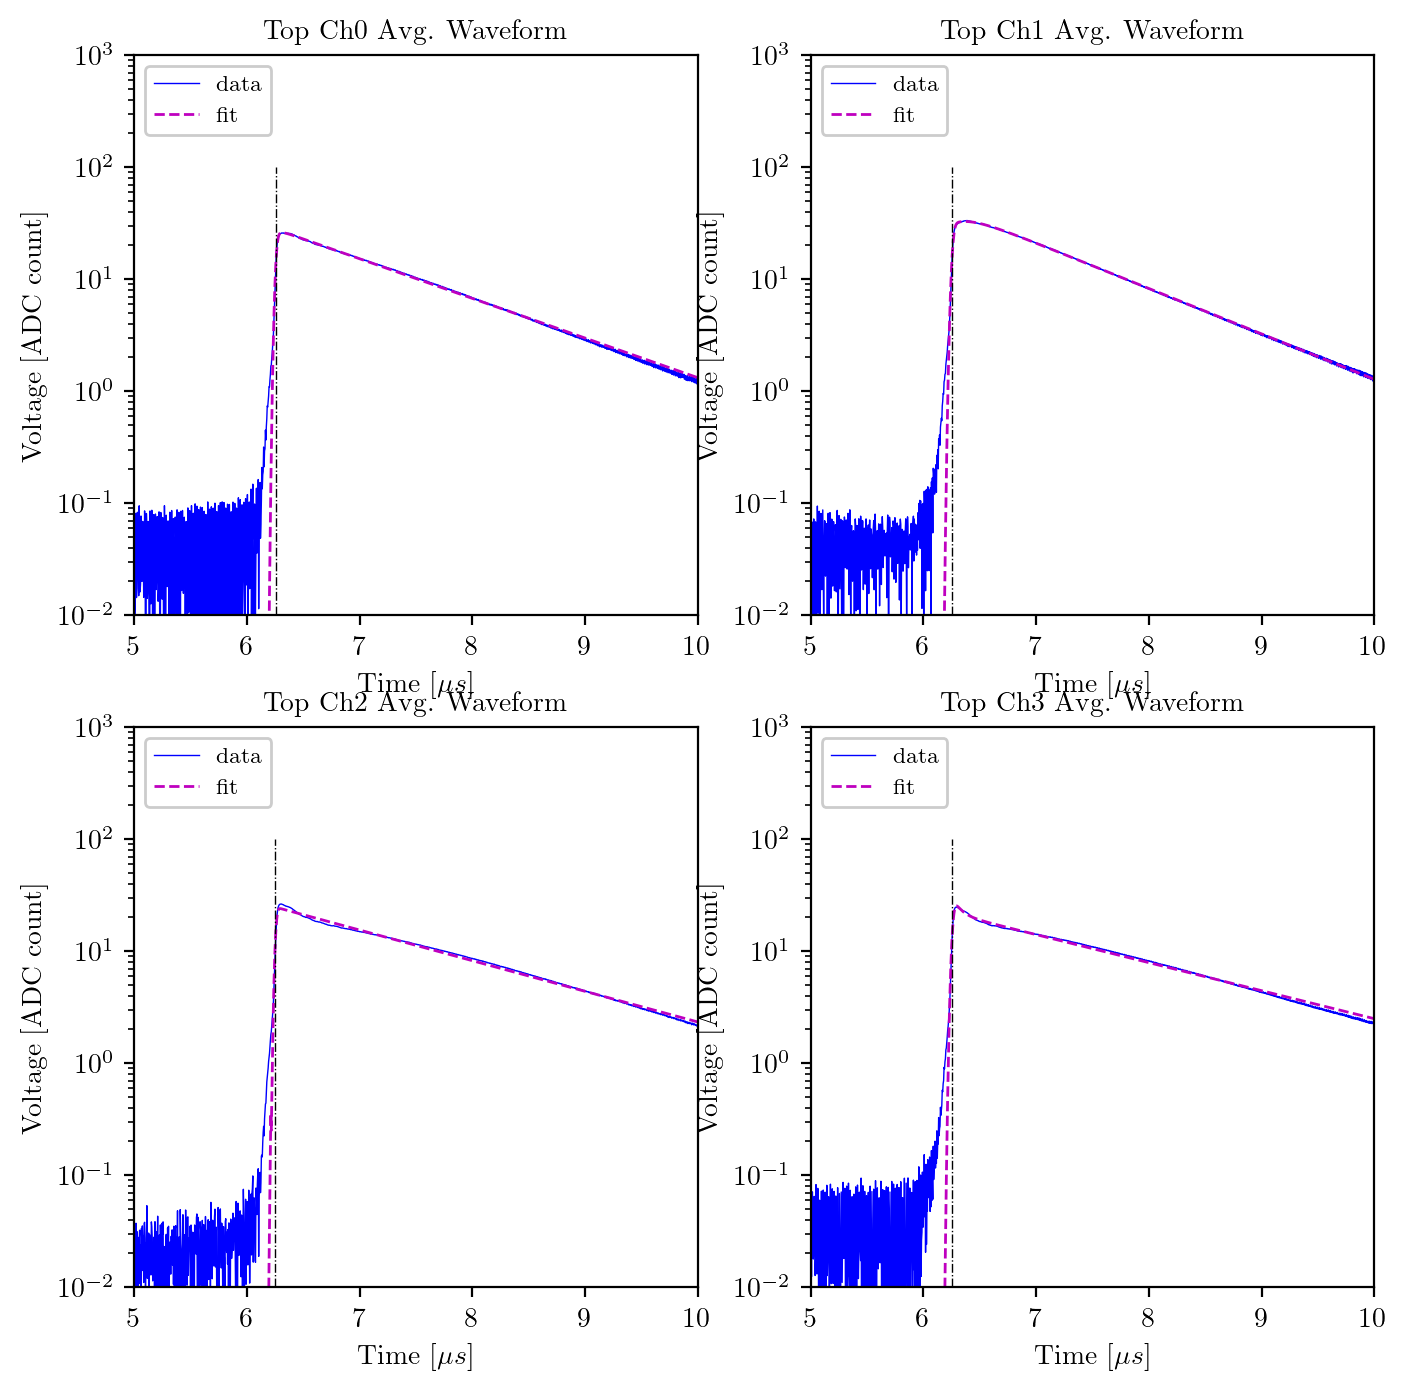

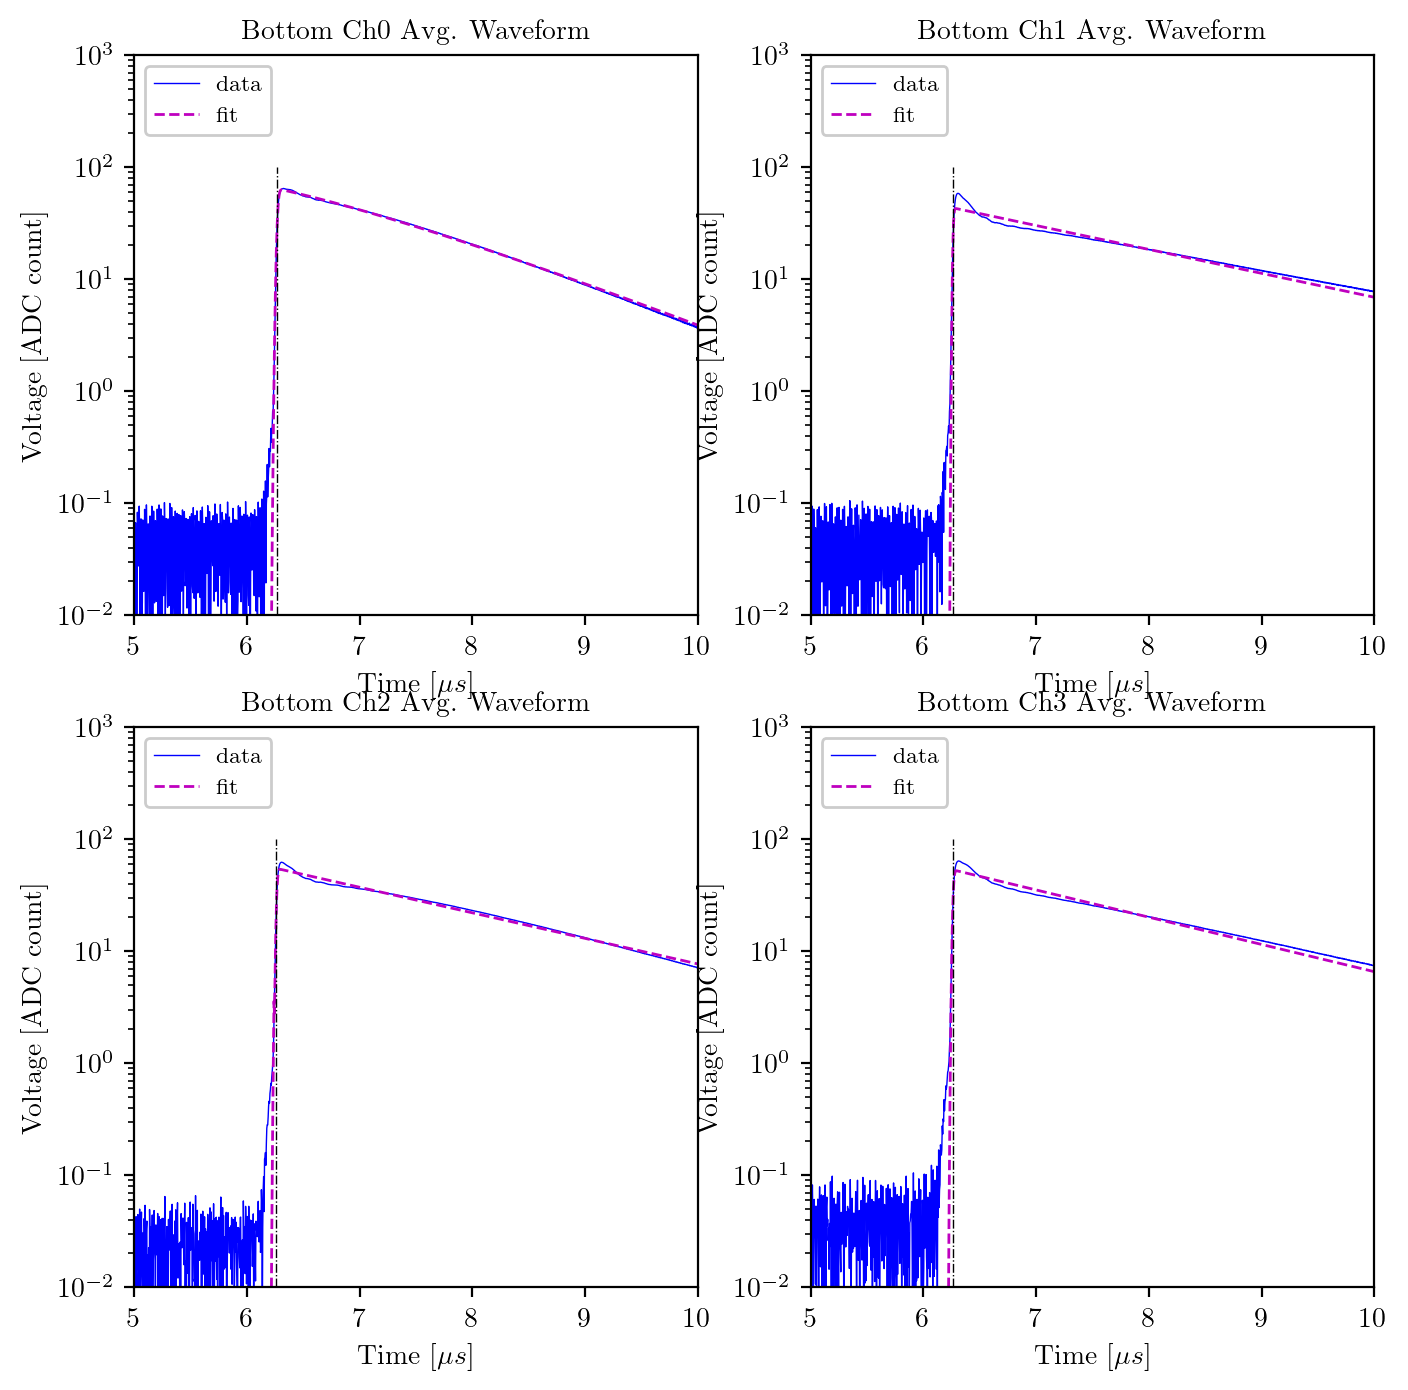

In [6]:
pos = ['Top', 'Bottom']
for i,dset in enumerate(ds1109):
    plt.figure(i,figsize=(8,8))
    for ch in range(4):
        if i==0:
            dset.ch[ch].set_pulse_pars(*pulse_pars_top[ch])
        else:
            dset.ch[ch].set_pulse_pars(*pulse_pars_bot[ch])
        t0 = dset.ch[ch].trigger_position-int(0.5/dset.ch[ch].sample_step)
        length = int(5/dset.ch[ch].sample_step)
        # print(t0*dset.ch[ch].sample_step, (t0+length)*dset.ch[ch].sample_step)
        err = np.std(dset.ch[ch].avgwf[:t0])
        popt,pcov = curve_fit(dset.ch[ch].get_scintillation, dset.ch[ch].time[t0:t0+length], abs(dset.ch[ch].avgwf[t0:t0+length]), p0=[100, 0.05, 15, 1.2, 0.01, 6.2], sigma=[err]*length, maxfev=100000)
        print('ch{} A_S={:.2f}+/-{:.2f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.2f}+/-{:.2f}  TAU_T={:.3f}+/-{:.3f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(ch,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
        dset.ch[ch].tau_singlet = [popt[1], np.sqrt(pcov[1,1])]
        dset.ch[ch].tau_triplet = [popt[3], np.sqrt(pcov[3,3])]
        plt.subplot(2,2,ch+1)
        plt.plot(dset.ch[ch].time, abs(dset.ch[ch].avgwf), "b-", label='data', linewidth=0.5)
        plt.plot(dset.ch[ch].time[t0:t0+length], dset.ch[ch].get_scintillation(dset.ch[ch].time[t0:t0+length], *popt), "m--", label='fit', linewidth=1.0)
        plt.plot([popt[5], popt[5]], [1e-2, 1e2], 'k-.', linewidth=0.5)
        plt.title('{} Ch{} Avg. Waveform'.format(pos[i],ch))
        plt.ylabel('Voltage [ADC count]')
        plt.xlabel(r'Time [$\mu s$]')
        plt.legend()
        plt.xlim(5,10)
        plt.ylim(1e-2, 1e3)
        plt.yscale('log')

# Try FFT-based deconvolution

ch0 A_S=0.68+/-0.02  TAU_S=0.0252+/-0.0010us  A_T=0.07+/-0.00  TAU_T=1.184+/-0.027us sigma=0.0107+/-0.0003us t0=6.248+/-0.000us
ch1 A_S=1.33+/-0.15  TAU_S=0.0120+/-0.0014us  A_T=0.17+/-0.00  TAU_T=0.668+/-0.014us sigma=0.0123+/-0.0005us t0=6.249+/-0.001us
ch2 A_S=0.74+/-0.02  TAU_S=0.0263+/-0.0007us  A_T=0.09+/-0.00  TAU_T=1.345+/-0.020us sigma=0.0104+/-0.0002us t0=6.247+/-0.000us
ch3 A_S=1.11+/-0.05  TAU_S=0.0144+/-0.0007us  A_T=0.04+/-0.00  TAU_T=1.819+/-0.041us sigma=0.0133+/-0.0003us t0=6.252+/-0.000us
ch0 A_S=1.66+/-0.02  TAU_S=0.0305+/-0.0005us  A_T=0.18+/-0.00  TAU_T=1.159+/-0.018us sigma=0.0083+/-0.0002us t0=6.257+/-0.000us
ch1 A_S=2.30+/-0.04  TAU_S=0.0192+/-0.0004us  A_T=0.12+/-0.00  TAU_T=1.731+/-0.034us sigma=0.0087+/-0.0002us t0=6.259+/-0.000us
ch2 A_S=2.03+/-0.02  TAU_S=0.0236+/-0.0003us  A_T=0.18+/-0.00  TAU_T=1.255+/-0.014us sigma=0.0089+/-0.0001us t0=6.255+/-0.000us
ch3 A_S=1.68+/-0.02  TAU_S=0.0342+/-0.0006us  A_T=0.24+/-0.00  TAU_T=1.296+/-0.018us sigma=0.0085+/-0.00

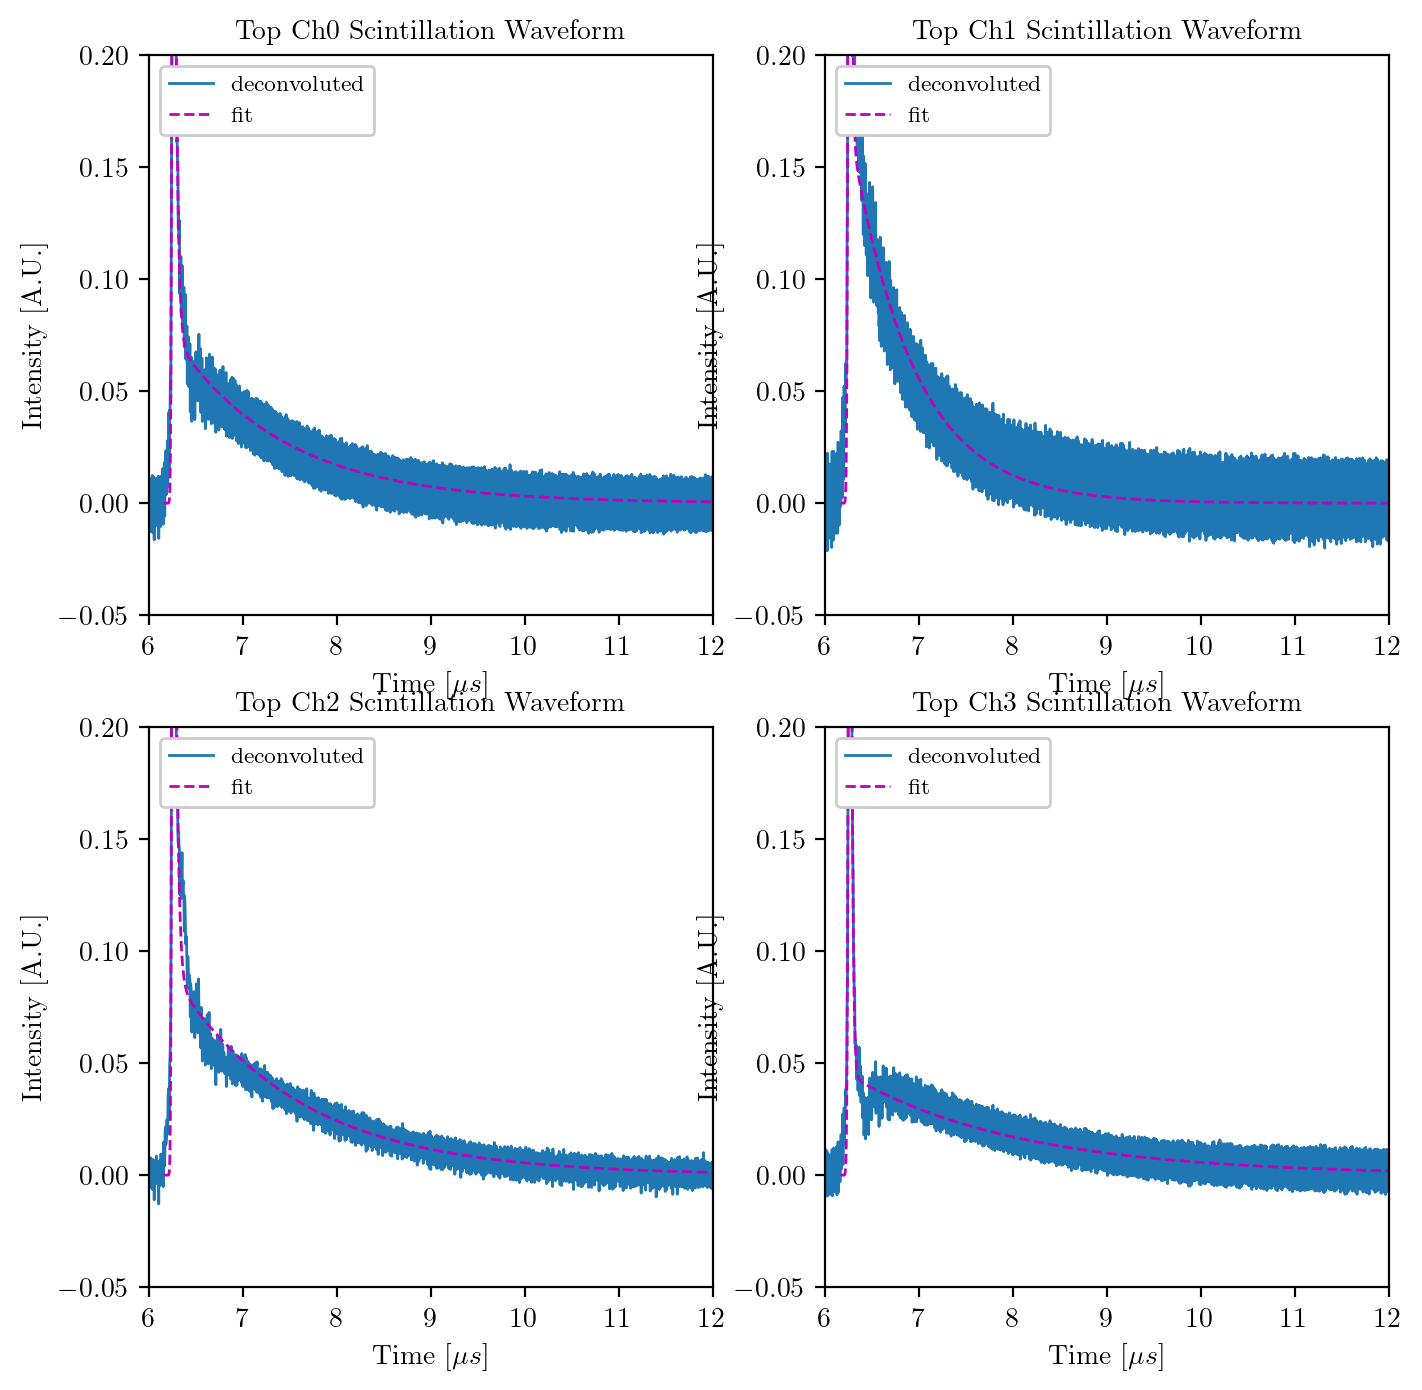

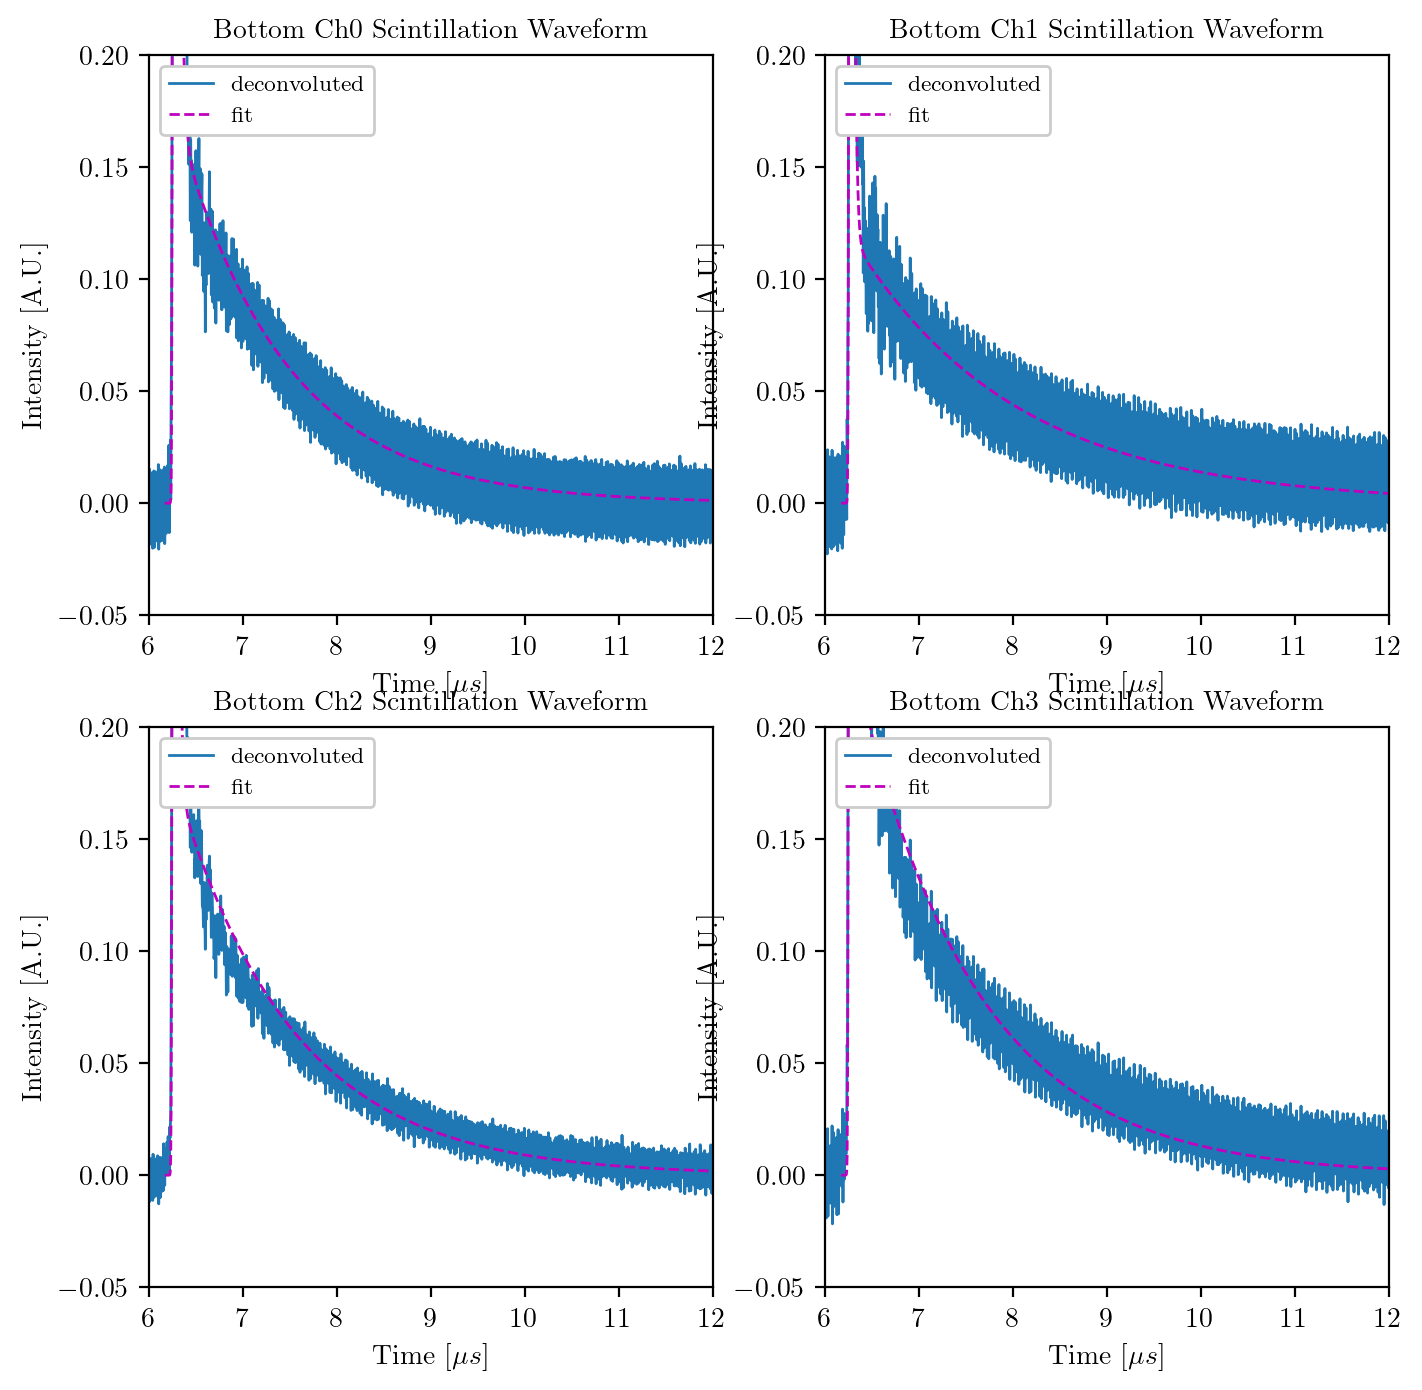

In [24]:
from scipy.fft import fft, ifft
pos = ['Top', 'Bottom']
f_deconv_sum = []
for i,dset in enumerate(ds1109):
    plt.figure(i,figsize=(8,8))
    f_deconv_sum_pos = np.zeros(dset.ch[0].samples)
    for ch in range(4):
        if i==0:
            dset.ch[ch].set_pulse_pars(*pulse_pars_top[ch])
        else:
            dset.ch[ch].set_pulse_pars(*pulse_pars_bot[ch])
        ftilde = fft(dset.ch[ch].avgwf)
        a1,tau1,a2,tau2 = dset.ch[ch].get_pulse_pars()
        h = lambda x: a1*np.exp(-x/tau1)+a2*np.exp(-x/tau2)
        htilde = fft(h(dset.ch[ch].time))
        f_deconv = ifft(ftilde/htilde).real
        f_deconv_sum_pos += f_deconv
        t0 = np.argmax(f_deconv)-int(0.1/dset.ch[ch].sample_step)
        length = int(6/dset.ch[ch].sample_step)
        err = np.std(dset.ch[ch].avgwf[:dset.ch[ch].baseline_samples])
        popt,pcov = curve_fit(dset.ch[ch].get_scintillation, dset.ch[ch].time[t0:t0+length], f_deconv[t0:t0+length], p0=[1, 0.02, 0.1, 1.2, 0.01, 6.25], sigma=[err]*length, maxfev=100000)
        print('ch{} A_S={:.2f}+/-{:.2f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.2f}+/-{:.2f}  TAU_T={:.3f}+/-{:.3f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(ch,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
        dset.ch[ch].tau_singlet = [popt[1], np.sqrt(pcov[1,1])]
        dset.ch[ch].tau_triplet = [popt[3], np.sqrt(pcov[3,3])]
        plt.subplot(2,2,ch+1)
        plt.plot(dset.ch[ch].time, f_deconv, label='deconvoluted', linewidth=1)
        plt.plot(dset.ch[ch].time[t0:t0+length], dset.ch[ch].get_scintillation(dset.ch[ch].time[t0:t0+length], *popt), "m--", label='fit', linewidth=1)
        plt.title('{} Ch{} Scintillation Waveform'.format(pos[i],ch))
        plt.ylabel('Intensity [A.U.]')
        plt.xlabel(r'Time [$\mu s$]')
        plt.legend()
        # plt.yscale('log')
        # plt.ylim(1e-3, 1e1)
        plt.ylim(-0.05,0.2)
        plt.xlim(6,12)
    f_deconv_sum.append(f_deconv_sum_pos)

Top A_S=0.8660+/-407804.0290  TAU_S=0.0750+/-0.0024us  A_T=0.3161+/-8768.4877  TAU_T=1.2720+/-0.0090us sigma=0.0031+/-1467.5750us t0=6.2181+/-35283.2107us
Bottom A_S=4.0773+/-8.4267  TAU_S=0.0869+/-0.0043us  A_T=0.6332+/-0.0969  TAU_T=1.5572+/-0.0102us sigma=0.0704+/-0.0850us t0=6.1488+/-0.2392us


/home/as111/sipm-analysis/sipm/sipm.py:25: RuntimeWarning: overflow encountered in exp
  return a*np.exp(sigma**2/2/tau**2)*np.exp(-(t-t0)/tau)*(1+erf((t-t0-sigma**2/tau)/sigma/np.sqrt(2)))/2
/home/as111/sipm-analysis/sipm/sipm.py:317: RuntimeWarning: invalid value encountered in add
  return pulse_jitter(t, a_s, tau_s, sigma, t0) + pulse_jitter(t, a_t, tau_t, sigma, t0)


(0.001, 10.0)

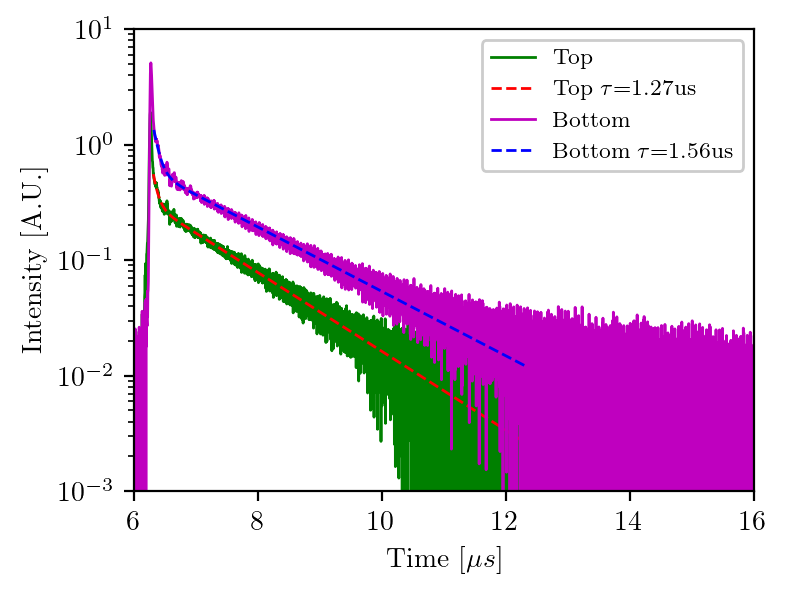

In [51]:
colors = ['g', 'm']
colors_fit = ['r','b']
labels = ['Top', 'Bottom']
for i,fdc in enumerate(f_deconv_sum):
    dset = ds1109[i].ch[0]
    t0 = np.argmax(fdc)+int(0.05/dset.sample_step)
    length = int(6/dset.sample_step)
    err = np.std(fdc[:dset.baseline_samples])
    popt,pcov = curve_fit(dset.get_scintillation, dset.time[t0:t0+length], fdc[t0:t0+length], p0=[5, 0.02, 0.5, 1.2, 0.01, 6.25], sigma=[err]*length, maxfev=100000)
    print('{} A_S={:.4f}+/-{:.4f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.4f}+/-{:.4f}  TAU_T={:.4f}+/-{:.4f}us sigma={:.4f}+/-{:.4f}us t0={:.4f}+/-{:.4f}us'.format(labels[i],popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
    plt.plot(dset.time, fdc, '{}-'.format(colors[i]), label=labels[i], linewidth=1)
    plt.plot(dset.time[t0:t0+length], dset.get_scintillation(dset.time[t0:t0+length], *popt), '{}--'.format(colors_fit[i]), label=r'{} $\tau$={:.2f}us'.format(labels[i], popt[3]), linewidth=1)
    
plt.legend(loc='upper right')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel('Intensity [A.U.]')
plt.yscale('log')
plt.xlim(6, 16)
plt.ylim(1e-3, 1e1)

In [28]:
selected_wfid = ds1109[0].get_waveforms_id(count=10, integral_range=(-5,0))
selected_wf = []
for ch in range(4):
    print(ds1109[0].ch[ch].trigger_position*ds1109[0].ch[0].sample_step)
    plt.figure(ch)
    selected_wf.append(ds1109[0].ch[ch].get_waveforms(event_id=selected_wfid))

6.172
6.152
6.172
6.168


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

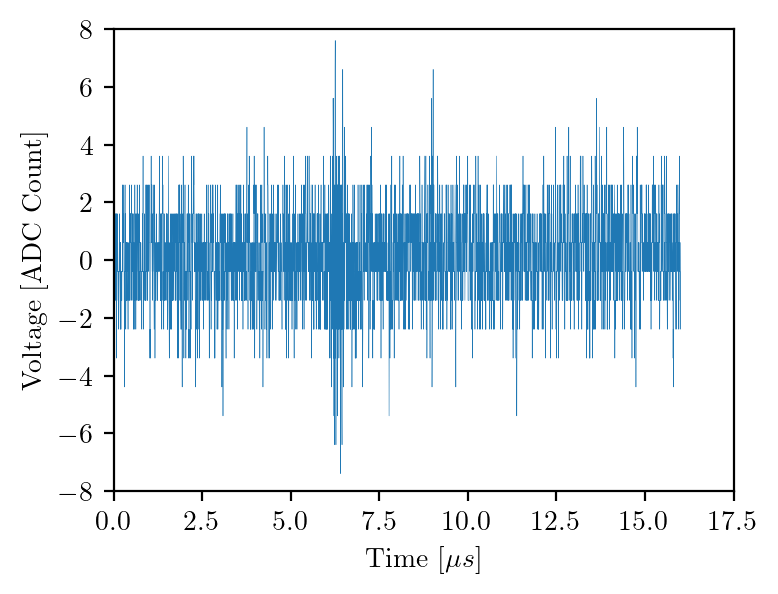

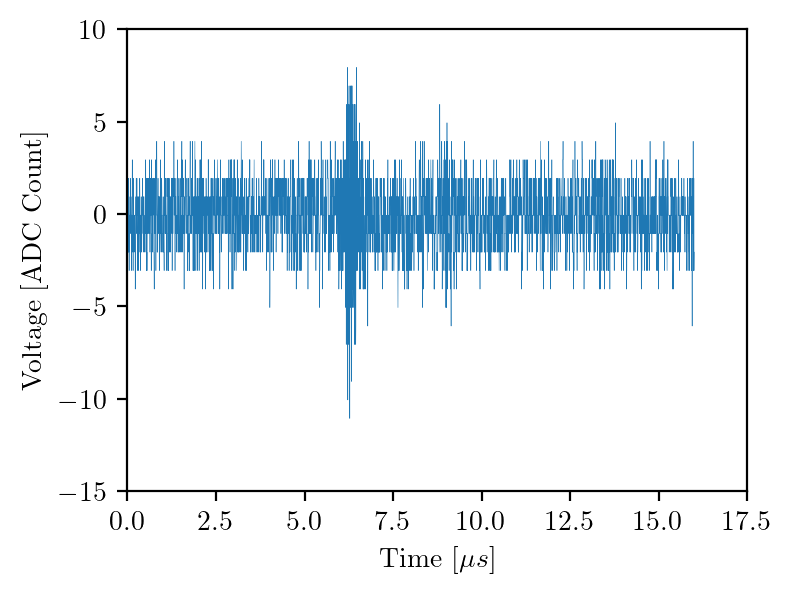

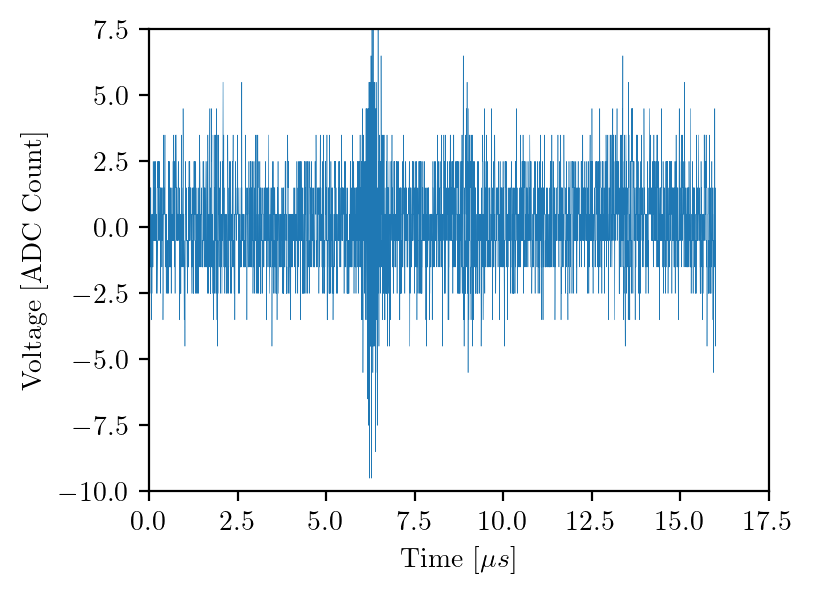

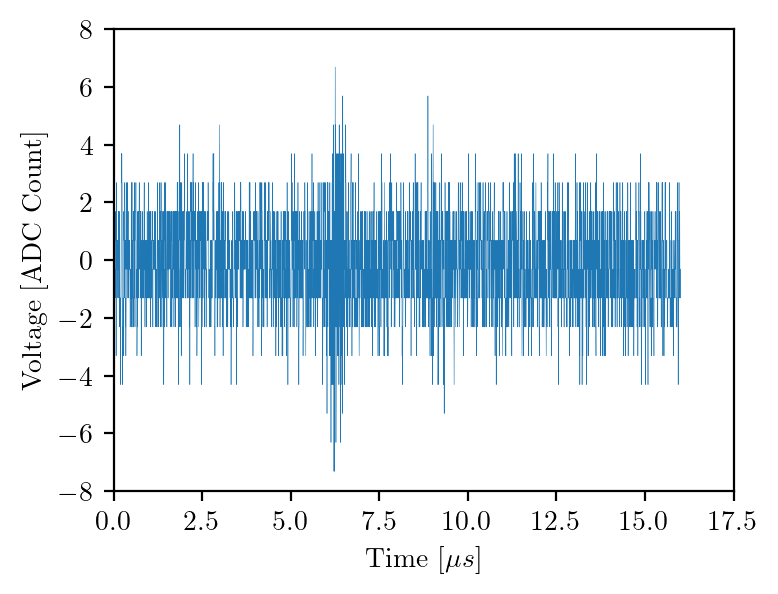

: 

In [29]:
tmin = 0
tmax = 16.0
tmin_sample = int(tmin/ds1109[0].ch[0].sample_step)
tmax_sample = int(tmax/ds1109[0].ch[0].sample_step)
for ch in range(4):
    plt.figure(ch)
    for iwf in range(1):
        plt.plot(ds1109[0].ch[ch].time[tmin_sample:tmax_sample], selected_wf[ch][iwf][tmin_sample:tmax_sample], linewidth=0.2)
    plt.xlabel(r'Time [$\mu s$]')
    plt.ylabel(r'Voltage [ADC Count]')